In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import jpholiday
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


### 日本の休日

In [3]:
i = 0
df['holiday'] = np.zeros((len(df),))
jpholiday_list =[]
for date in df['datetime'].dt.date:
    DateJ = dt.date(date.year,date.month,date.day)
    jpholiday_list.append(jpholiday.is_holiday(DateJ))
    i += 1

df['holiday'] = jpholiday_list    
df['holiday'].value_counts()

False    2353
True      113
Name: holiday, dtype: int64

In [4]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.loc[df['close'] == 1, 'price_am'] = 0
df.loc[df['close'] == 1, 'price_pm'] = 0
df.head()

,datetime,y,client,close,price_am,price_pm,holiday
0,2010-07-01,17.0,0,0,NaN,NaN,False
1,2010-07-02,18.0,0,0,NaN,NaN,False
2,2010-07-03,20.0,0,0,NaN,NaN,False
3,2010-07-04,20.0,0,0,NaN,NaN,False
4,2010-07-05,14.0,0,0,NaN,NaN,False


In [5]:
### datimeをdatetime64[ns]型に変更。

In [6]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [7]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [8]:
df = encode(df, 'month')
df = encode(df, 'day')
df = encode(df, 'weekday')

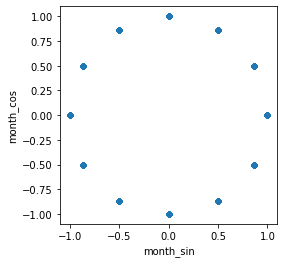

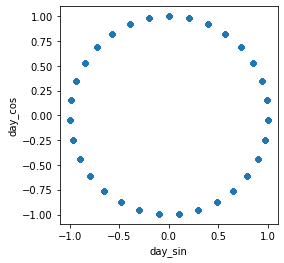

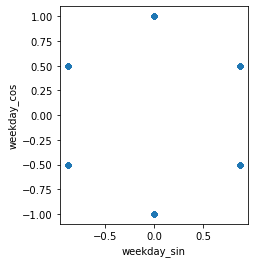

In [9]:
df.plot.scatter('month_sin','month_cos').set_aspect('equal')
df.plot.scatter('day_sin','day_cos').set_aspect('equal')
df.plot.scatter('weekday_sin','weekday_cos').set_aspect('equal')

In [10]:
df.head()
#df.info()
#df['epoch'] = df['datetime'].map(pd.Timestamp.timestamp) # TimeStamp型に変更
#display(df['epoch'])

,datetime,y,client,close,price_am,price_pm,holiday,year,month,day,weekday,month_cos,month_sin,day_cos,day_sin,weekday_cos,weekday_sin
0,2010-07-01,17.0,0,0,NaN,NaN,False,2010,7,1,3,-0.866025,-0.5,0.979530,0.201299,-1.0,1.224647e-16
1,2010-07-02,18.0,0,0,NaN,NaN,False,2010,7,2,4,-0.866025,-0.5,0.918958,0.394356,-0.5,-8.660254e-01
2,2010-07-03,20.0,0,0,NaN,NaN,False,2010,7,3,5,-0.866025,-0.5,0.820763,0.571268,0.5,-8.660254e-01
3,2010-07-04,20.0,0,0,NaN,NaN,False,2010,7,4,6,-0.866025,-0.5,0.688967,0.724793,1.0,-2.449294e-16
4,2010-07-05,14.0,0,0,NaN,NaN,False,2010,7,5,0,-0.866025,-0.5,0.528964,0.848644,1.0,0.000000e+00


In [11]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [12]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

In [13]:
# 各月,曜日ごとの価格のばらつき
df['price_am_std'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.std())
df['price_pm_std'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.std())

### New features

In [14]:
df['price'] = (df['price_am'] + df['price_pm'])/2
df['price_times'] = df['price_am'] * df['price_pm']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2101 non-null   float64
 1   client        2466 non-null   int64  
 2   close         2466 non-null   int64  
 3   price_am      2466 non-null   float64
 4   price_pm      2466 non-null   float64
 5   holiday       2466 non-null   bool   
 6   year          2466 non-null   int64  
 7   month         2466 non-null   int64  
 8   day           2466 non-null   int64  
 9   weekday       2466 non-null   int64  
 10  month_cos     2466 non-null   float64
 11  month_sin     2466 non-null   float64
 12  day_cos       2466 non-null   float64
 13  day_sin       2466 non-null   float64
 14  weekday_cos   2466 non-null   float64
 15  weekday_sin   2466 non-null   float64
 16  price_am_std  2466 non-null   float64
 17  price_pm_std  2466 non-null   float64
 18  price         2466 non-null  

In [16]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.129032  0.000000  23.423077
      1        0.096774  0.064516  21.846154
      2        0.033333  0.000000  22.692308
      3        0.161290  0.096774  21.296296
      4        0.258065  0.161290  27.444444
      5        0.806452  0.419355  36.296296
      6        0.375000  0.218750  32.666667
2     0        0.586207  0.344828  40.160000
      1        0.357143  0.178571  34.083333
      2        0.379310  0.206897  34.440000
      3        0.357143  0.142857  34.041667
      4        0.821429  0.500000  39.083333
      5        2.071429  1.535714  46.416667
      6        1.392857  0.892857  43.000000
3     0        1.933333  1.666667  58.576923
      1        2.000000  1.580645  59.185185
      2        1.838710  1.709677  56.500000
      3        2.031250  1.656250  56.814815
      4        2.096774  2.032258  58.038462
      5        3.096774  2.741935  59.407407
      6   

<ipython-input-16-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-16-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [17]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
# df['day'] = df['day'].astype(str)
#df=df.drop(['month'], axis=1)
#df=df.drop(['day'], axis=1)
#df=df.drop(['weekday'], axis=1)

In [18]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'holiday', 'year', 'day', 'month_cos', 'month_sin', 'day_cos', 'day_sin', 'weekday_cos', 'weekday_sin', 'price_am_std', 'price_pm_std', 'price', 'price_times']


### Pandas Profining

In [19]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

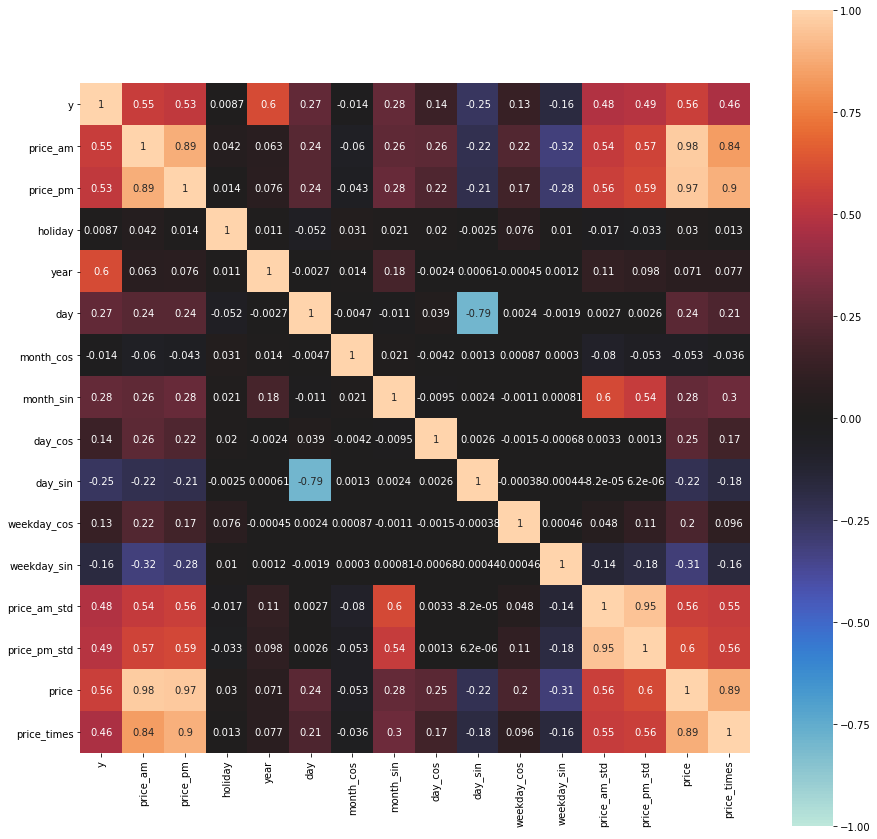

In [20]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


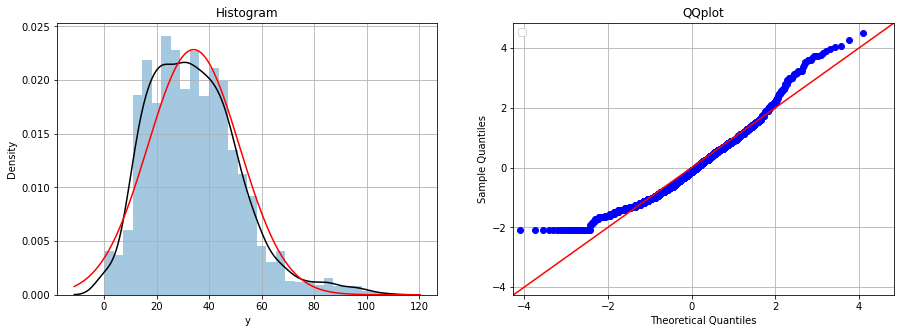

In [21]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [22]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [23]:
df.head(10)

,y,price_am,price_pm,holiday,year,day,month_cos,month_sin,day_cos,day_sin,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,False,2010,1,-0.866025,-0.5,0.979530,0.201299,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,False,2010,2,-0.866025,-0.5,0.918958,0.394356,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,False,2010,3,-0.866025,-0.5,0.820763,0.571268,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,False,2010,4,-0.866025,-0.5,0.688967,0.724793,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,False,2010,5,-0.866025,-0.5,0.528964,0.848644,...,0,1,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,False,2010,6,-0.866025,-0.5,0.347305,0.937752,...,0,1,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,False,2010,7,-0.866025,-0.5,0.151428,0.988468,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,False,2010,8,-0.866025,-0.5,-0.050649,0.998717,...,0,1,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,False,2010,9,-0.866025,-0.5,-0.250653,0.968077,...,0,1,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,False,2010,10,-0.866025,-0.5,-0.440394,0.897805,...,0,1,0,0,0,0,0,0,1,0


### Separate Data

In [24]:
train = df[:len(train)]
test = df[len(train):]

In [25]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [26]:
### 線形回帰

In [27]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [28]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2101 non-null   float64
 1   price_am      2466 non-null   float64
 2   price_pm      2466 non-null   float64
 3   holiday       2466 non-null   bool   
 4   year          2466 non-null   int64  
 5   day           2466 non-null   int64  
 6   month_cos     2466 non-null   float64
 7   month_sin     2466 non-null   float64
 8   day_cos       2466 non-null   float64
 9   day_sin       2466 non-null   float64
 10  weekday_cos   2466 non-null   float64
 11  weekday_sin   2466 non-null   float64
 12  price_am_std  2466 non-null   float64
 13  price_pm_std  2466 non-null   float64
 14  price         2466 non-null   float64
 15  price_times   2466 non-null   float64
 16  client_1      2466 non-null   uint8  
 17  close_1       2466 non-null   uint8  
 18  month_10      2466 non-null  

,y,price_am,price_pm,holiday,year,day,month_cos,month_sin,day_cos,day_sin,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,False,2010,1,-0.866025,-0.5,0.979530,0.201299,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,False,2010,2,-0.866025,-0.5,0.918958,0.394356,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,False,2010,3,-0.866025,-0.5,0.820763,0.571268,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,False,2010,4,-0.866025,-0.5,0.688967,0.724793,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,False,2010,5,-0.866025,-0.5,0.528964,0.848644,...,0,1,0,0,0,0,0,0,0,0


In [29]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [30]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.03981071705534823}
R^2 = 0.755177962166645
MAE = 6.7126026789130435


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.4434912398865, tolerance: 64.13793860066639
  model = cd_fast.enet_coordinate_descent(


In [31]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

evals_result = {} #結果を格納するための辞書

In [32]:
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [33]:
def ScalerFit(X_tr, X_tst):
    scaler.fit(X_tr)
    scaler.fit(X_tst)
    X_tr_scaler = scaler.transform(X_tr)
    X_tst_scaler  = scaler.transform(X_tst)
    return X_tr_scaler, X_tst_scaler

In [34]:
def SVC_fit(random_sts):
    # SVM
    params_grid = [
        {'C': [1, 10, 100], 'kernel':['linear']},
        {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
    ]
    # パラメータチューニング
    clf = GridSearchCV(
        estimator = SVC(),
        param_grid = params_grid,
        cv = 5,
        scoring='r2',
        n_jobs = -1
        )

    # フィッテイング
    clf.fit(X_train_scaler, y_train) 

    # チューニングしたモデル
    best_param = clf.best_params_
    svc_tuned = clf.best_estimator_

    # 予測値を反映
    y_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
    y_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

    print(best_param)
    print("Score = {}".format(clf.score(X_train_scaler, y_train)))
    print("MAE = {}".format(mean_absolute_error(y_train, y_pred)))
    mae_result = mean_absolute_error(y_train, y_pred)
    
    X_train['svc'] = y_pred
    X_test['svc'] = y_test_pred

    return y_pred, y_test_pred, mae_result
    

In [35]:
def lightGBM_fit(random_sts):
    y_lgb_preds = []
    models = []
    y_lgb_oof_train = np.zeros((len(X_train),))
    cv = KFold(n_splits=5, shuffle=True, random_state=random_sts)

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective': 'regression',
        'metric' : 'rmse',
        'max_bin' : 255,
        'num_leaves' : 31,
        'learning_rate' : 0.05,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : -1
    }

    # Cross Validation
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]
    
        # Train Dataset
        lgb_train = lgb.Dataset(X_tr, y_tr)

        # Evaluation Dataset (early_stopping_rounds)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
 #       evals_result = {} #結果を格納するための辞書
        # train
        gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
        # Out-of-hold of train data
        y_lgb_oof_train[valid_index] = \
            gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
        # Prediction for X_test data
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
        # Append Prediction data 
        y_lgb_preds.append(y_pred)
        models.append(gbm)

    mae_result = mean_absolute_error(y_train, y_lgb_oof_train)
    print("MAE = {}".format(mae_result))
    
    X_train['lgb'] = y_lgb_oof_train
    X_test['lgb'] = sum(y_lgb_preds)/len(y_lgb_preds)

    return y_lgb_oof_train, y_lgb_preds, mae_result

In [36]:
svc_mae_result = []
lgb_mae_result = []
for i in range(0,1):
    y_svc_pred, y_svc_test_pred,mae_result = SVC_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    svc_mae_result.append(mae_result)
    print(X_train.tail())
    y_lgb_oof_train, y_lgb_preds, mae_result = lightGBM_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    lgb_mae_result.append(mae_result)
    print(X_train.tail())

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


[I 2021-06-23 11:26:45,102] A new study created in memory with name: no-name-3d20135d-53ac-4a11-bbec-57a340f80bed
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Score = 0.8636937795205477
MAE = 3.561161351737268
      price_am  price_pm  holiday  year  day     month_cos  month_sin  \
2096       5.0       4.0    False  2016   27  6.123234e-17        1.0   
2097       4.0       4.0    False  2016   28  6.123234e-17        1.0   
2098       4.0       4.0    False  2016   29  6.123234e-17        1.0   
2099       5.0       4.0    False  2016   30  6.123234e-17        1.0   
2100       5.0       4.0    False  2016   31  6.123234e-17        1.0   

       day_cos       day_sin  weekday_cos  ...  month_7  month_8  month_9  \
2096  0.688967 -7.247928e-01          1.0  ...        0        0        0   
2097  0.820763 -5.712682e-01          1.0  ...        0        0        0   
2098  0.918958 -3.943559e-01          0.5  ...        0        0        0   
2099  0.979530 -2.012985e-01         -0.5  ...        0        0        0   
2100  1.000000 -2.449294e-16         -1.0  ...        0        0        0   

      weekday_1  weekday_2  weekday_3  weekday_

feature_fraction, val_score: 6.684765:  14%|7    | 1/7 [00:00<00:02,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.34867	eval's rmse: 6.69263


feature_fraction, val_score: 6.637274:  29%|#4   | 2/7 [00:00<00:01,  2.50it/s]

[200]	train's rmse: 3.48365	eval's rmse: 6.65135
Early stopping, best iteration is:
[154]	train's rmse: 3.80525	eval's rmse: 6.63727
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 6.637274:  43%|##1  | 3/7 [00:01<00:01,  2.64it/s]

[100]	train's rmse: 4.34064	eval's rmse: 6.75223
[200]	train's rmse: 3.45865	eval's rmse: 6.72488
Early stopping, best iteration is:
[129]	train's rmse: 4.02061	eval's rmse: 6.71478
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.36009	eval's rmse: 6.63662


feature_fraction, val_score: 6.562744:  57%|##8  | 4/7 [00:01<00:01,  2.50it/s]

[200]	train's rmse: 3.51263	eval's rmse: 6.5825
Early stopping, best iteration is:
[161]	train's rmse: 3.7862	eval's rmse: 6.56274
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.41857	eval's rmse: 6.51831
[200]	train's rmse: 3.56421	eval's rmse: 6.48116
Early stopping, best iteration is:
[159]	train's rmse: 3.85032	eval's rmse: 6.44232


feature_fraction, val_score: 6.442315:  71%|###5 | 5/7 [00:02<00:00,  2.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.55678	eval's rmse: 6.59959
[200]	train's rmse: 3.69602	eval's rmse: 6.46169


feature_fraction, val_score: 6.440740:  86%|####2| 6/7 [00:02<00:00,  2.58it/s]

Early stopping, best iteration is:
[162]	train's rmse: 3.94565	eval's rmse: 6.44074
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.45213	eval's rmse: 6.52525


num_leaves, val_score: 6.396627:   0%|                  | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 3.59134	eval's rmse: 6.43378
Early stopping, best iteration is:
[162]	train's rmse: 3.84707	eval's rmse: 6.39663
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866


num_leaves, val_score: 6.396627:   5%|5         | 1/20 [00:00<00:08,  2.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656


num_leaves, val_score: 6.396627:  10%|#         | 2/20 [00:00<00:08,  2.05it/s]

[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879


num_leaves, val_score: 6.396627:  15%|#5        | 3/20 [00:01<00:08,  2.12it/s]

Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866


num_leaves, val_score: 6.396627:  20%|##        | 4/20 [00:01<00:07,  2.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656


num_leaves, val_score: 6.396627:  25%|##5       | 5/20 [00:02<00:07,  2.13it/s]

[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879


num_leaves, val_score: 6.396627:  30%|###       | 6/20 [00:02<00:06,  2.09it/s]

Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866


num_leaves, val_score: 6.396627:  35%|###5      | 7/20 [00:03<00:06,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656


num_leaves, val_score: 6.396627:  40%|####      | 8/20 [00:03<00:05,  2.14it/s]

[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879


num_leaves, val_score: 6.396627:  45%|####5     | 9/20 [00:04<00:05,  2.16it/s]

Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879


num_leaves, val_score: 6.396627:  50%|####5    | 10/20 [00:04<00:04,  2.13it/s]

Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.45213	eval's rmse: 6.52525
[200]	train's rmse: 3.59134	eval's rmse: 6.43378
Early stopping, best iteration is:
[162]	train's rmse: 3.84707	eval's rmse: 6.39663

num_leaves, val_score: 6.396627:  55%|####9    | 11/20 [00:05<00:04,  2.04it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.22365	eval's rmse: 6.53735
[200]	train's rmse: 3.30699	eval's rmse: 6.50639


num_leaves, val_score: 6.396627:  60%|#####3   | 12/20 [00:05<00:03,  2.07it/s]

Early stopping, best iteration is:
[154]	train's rmse: 3.65374	eval's rmse: 6.46521
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.86918	eval's rmse: 6.73668
[200]	train's rmse: 5.44751	eval's rmse: 6.5507
[300]	train's rmse: 5.22177	eval's rmse: 6.4944
[400]	train's rmse: 5.05143	eval's rmse: 6.46489
[500]	train's rmse: 4.91173	eval's rmse: 6.44997
[600]	train's rmse: 4.78792	eval's rmse: 6.42566
[700]	train's rmse: 4.67482	eval's rmse: 6.40638


num_leaves, val_score: 6.388261:  65%|#####8   | 13/20 [00:06<00:03,  2.12it/s]

Early stopping, best iteration is:
[652]	train's rmse: 4.72244	eval's rmse: 6.38826
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261


num_leaves, val_score: 6.281486:  70%|######3  | 14/20 [00:06<00:02,  2.25it/s]

[300]	train's rmse: 4.4162	eval's rmse: 6.32141
[400]	train's rmse: 4.1503	eval's rmse: 6.30521
Early stopping, best iteration is:
[374]	train's rmse: 4.21267	eval's rmse: 6.28149
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21014	eval's rmse: 6.9419
[200]	train's rmse: 5.79451	eval's rmse: 6.67691
[300]	train's rmse: 5.61672	eval's rmse: 6.6099
[400]	train's rmse: 5.50218	eval's rmse: 6.55868
[500]	train's rmse: 5.41504	eval's rmse: 6.53923
[600]	train's rmse: 5.3344	eval's rmse: 6.53944


num_leaves, val_score: 6.281486:  75%|######7  | 15/20 [00:06<00:02,  2.31it/s]

[700]	train's rmse: 5.26194	eval's rmse: 6.509
Early stopping, best iteration is:
[681]	train's rmse: 5.27209	eval's rmse: 6.49808
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656
[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866


num_leaves, val_score: 6.281486:  80%|#######2 | 16/20 [00:07<00:01,  2.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7613	eval's rmse: 6.66465
[200]	train's rmse: 5.29822	eval's rmse: 6.49411
[300]	train's rmse: 5.04703	eval's rmse: 6.43506
[400]	train's rmse: 4.84455	eval's rmse: 6.38079


num_leaves, val_score: 6.281486:  85%|#######6 | 17/20 [00:07<00:01,  2.24it/s]

[500]	train's rmse: 4.68573	eval's rmse: 6.35332
[600]	train's rmse: 4.55798	eval's rmse: 6.33891
[700]	train's rmse: 4.43954	eval's rmse: 6.32696
Early stopping, best iteration is:
[652]	train's rmse: 4.48556	eval's rmse: 6.31916
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.14042	eval's rmse: 6.53656


num_leaves, val_score: 6.281486:  90%|########1| 18/20 [00:08<00:00,  2.24it/s]

[200]	train's rmse: 3.158	eval's rmse: 6.52879
Early stopping, best iteration is:
[129]	train's rmse: 3.78333	eval's rmse: 6.47866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.12208	eval's rmse: 6.5678
[200]	train's rmse: 3.1519	eval's rmse: 6.4998


num_leaves, val_score: 6.281486:  95%|########5| 19/20 [00:08<00:00,  2.16it/s]

Early stopping, best iteration is:
[163]	train's rmse: 3.44162	eval's rmse: 6.48327
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.92886	eval's rmse: 6.53531
[200]	train's rmse: 4.22977	eval's rmse: 6.40274
[300]	train's rmse: 3.84066	eval's rmse: 6.4308

bagging, val_score: 6.281486:   0%|                     | 0/10 [00:00<?, ?it/s]


Early stopping, best iteration is:
[204]	train's rmse: 4.20732	eval's rmse: 6.39503
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47712	eval's rmse: 6.66222
[200]	train's rmse: 4.93486	eval's rmse: 6.46845
[300]	train's rmse: 4.64274	eval's rmse: 6.42709
[400]	train's rmse: 4.40145	eval's rmse: 6.41497
[500]	train's rmse: 4.21845	eval's rmse: 6.39523


bagging, val_score: 6.281486:  10%|#3           | 1/10 [00:00<00:04,  1.95it/s]

[600]	train's rmse: 4.06018	eval's rmse: 6.4309
Early stopping, best iteration is:
[558]	train's rmse: 4.1277	eval's rmse: 6.37925
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37701	eval's rmse: 6.65566


bagging, val_score: 6.281486:  10%|#3           | 1/10 [00:00<00:04,  1.95it/s]

[200]	train's rmse: 4.80425	eval's rmse: 6.46881
[300]	train's rmse: 4.49396	eval's rmse: 6.43053
[400]	train's rmse: 4.25173	eval's rmse: 6.44417
Early stopping, best iteration is:
[365]	train's rmse: 4.33179	eval's rmse: 6.41507


bagging, val_score: 6.281486:  20%|##6          | 2/10 [00:00<00:03,  2.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50104	eval's rmse: 6.6862
[200]	train's rmse: 4.98306	eval's rmse: 6.43522
[300]	train's rmse: 4.67744	eval's rmse: 6.43743


bagging, val_score: 6.281486:  30%|###9         | 3/10 [00:01<00:02,  2.68it/s]

Early stopping, best iteration is:
[272]	train's rmse: 4.75564	eval's rmse: 6.40735
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38593	eval's rmse: 6.65221
[200]	train's rmse: 4.82316	eval's rmse: 6.51002
[300]	train's rmse: 4.49814	eval's rmse: 6.47564
[400]	train's rmse: 4.25914	eval's rmse: 6.4807
[500]	train's rmse: 4.06495	eval's rmse: 6.47117
Early stopping, best iteration is:
[430]	train's rmse: 4.19407	eval's rmse: 6.44866


bagging, val_score: 6.281486:  40%|#####2       | 4/10 [00:01<00:02,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.26628	eval's rmse: 6.42342
[200]	train's rmse: 4.71578	eval's rmse: 6.32745


bagging, val_score: 6.281486:  50%|######5      | 5/10 [00:02<00:02,  2.42it/s]

[300]	train's rmse: 4.39818	eval's rmse: 6.29552
[400]	train's rmse: 4.13487	eval's rmse: 6.28504
Early stopping, best iteration is:
[393]	train's rmse: 4.15024	eval's rmse: 6.28327
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4984	eval's rmse: 6.73247
[200]	train's rmse: 4.95362	eval's rmse: 6.59376
[300]	train's rmse: 4.65227	eval's rmse: 6.51109
[400]	train's rmse: 4.41737	eval's rmse: 6.45394


bagging, val_score: 6.281486:  60%|#######8     | 6/10 [00:02<00:01,  2.36it/s]

[500]	train's rmse: 4.23418	eval's rmse: 6.4567
Early stopping, best iteration is:
[468]	train's rmse: 4.2858	eval's rmse: 6.42673
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53225	eval's rmse: 6.72141


bagging, val_score: 6.281486:  70%|#########1   | 7/10 [00:02<00:01,  2.52it/s]

[200]	train's rmse: 4.97493	eval's rmse: 6.60941
[300]	train's rmse: 4.68721	eval's rmse: 6.53538
[400]	train's rmse: 4.46103	eval's rmse: 6.56778
Early stopping, best iteration is:
[327]	train's rmse: 4.62251	eval's rmse: 6.49415
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41814	eval's rmse: 6.61968
[200]	train's rmse: 4.82536	eval's rmse: 6.47237


bagging, val_score: 6.281486:  80%|##########4  | 8/10 [00:03<00:00,  2.46it/s][I 2021-06-23 11:27:00,409] Trial 34 finished with value: 6.392764092172855 and parameters: {'bagging_fraction': 0.6199088780962123, 'bagging_freq': 2}. Best is trial 31 with value: 6.283265821332772.


[300]	train's rmse: 4.50911	eval's rmse: 6.43679
[400]	train's rmse: 4.26152	eval's rmse: 6.41678
[500]	train's rmse: 4.0572	eval's rmse: 6.40507
Early stopping, best iteration is:
[423]	train's rmse: 4.20976	eval's rmse: 6.39276


bagging, val_score: 6.281486:  80%|##########4  | 8/10 [00:03<00:00,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34369	eval's rmse: 6.52878
[200]	train's rmse: 4.75354	eval's rmse: 6.39872
[300]	train's rmse: 4.44256	eval's rmse: 6.3996


bagging, val_score: 6.281486:  90%|###########7 | 9/10 [00:03<00:00,  2.72it/s]

Early stopping, best iteration is:
[212]	train's rmse: 4.7069	eval's rmse: 6.38577
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31769	eval's rmse: 6.51651


feature_fraction_stage2, val_score: 6.281486:   0%|      | 0/6 [00:00<?, ?it/s]

[200]	train's rmse: 4.74287	eval's rmse: 6.35837
[300]	train's rmse: 4.41026	eval's rmse: 6.35601
Early stopping, best iteration is:
[274]	train's rmse: 4.48924	eval's rmse: 6.32632
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.281486:  17%|1| 1/6 [00:00<00:01,  3.43it[I 2021-06-23 11:27:01,359] Trial 37 finished with value: 6.318679277443003 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 6.318679277443003.
feature_fraction_stage2, val_score: 6.281486:  17%|1| 1/6 [00:00<00:01,  3.43it

[100]	train's rmse: 5.32962	eval's rmse: 6.48973
[200]	train's rmse: 4.74628	eval's rmse: 6.35396
[300]	train's rmse: 4.44432	eval's rmse: 6.32959
Early stopping, best iteration is:
[256]	train's rmse: 4.56766	eval's rmse: 6.31868
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39562	eval's rmse: 6.54822
[200]	train's rmse: 4.78986	eval's rmse: 6.39358
[300]	train's rmse: 4.46343	eval's rmse: 6.36577


feature_fraction_stage2, val_score: 6.281486:  33%|3| 2/6 [00:00<00:01,  3.16it[I 2021-06-23 11:27:01,698] Trial 38 finished with value: 6.325727207916075 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 6.318679277443003.
feature_fraction_stage2, val_score: 6.281486:  33%|3| 2/6 [00:00<00:01,  3.16it

[400]	train's rmse: 4.18966	eval's rmse: 6.34489
Early stopping, best iteration is:
[374]	train's rmse: 4.25114	eval's rmse: 6.32573
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40736	eval's rmse: 6.55349


feature_fraction_stage2, val_score: 6.281486:  33%|3| 2/6 [00:00<00:01,  3.16it

[200]	train's rmse: 4.79491	eval's rmse: 6.37589
[300]	train's rmse: 4.47229	eval's rmse: 6.34404
[400]	train's rmse: 4.20755	eval's rmse: 6.33629
Early stopping, best iteration is:
[392]	train's rmse: 4.22673	eval's rmse: 6.32902


feature_fraction_stage2, val_score: 6.281486:  50%|5| 3/6 [00:00<00:00,  3.01it[I 2021-06-23 11:27:02,043] Trial 39 finished with value: 6.32902276503891 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 6.318679277443003.
feature_fraction_stage2, val_score: 6.281486:  50%|5| 3/6 [00:00<00:00,  3.01it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31107	eval's rmse: 6.52264
[200]	train's rmse: 4.71609	eval's rmse: 6.3302
[300]	train's rmse: 4.39701	eval's rmse: 6.3132


feature_fraction_stage2, val_score: 6.281486:  67%|6| 4/6 [00:01<00:00,  2.90it[I 2021-06-23 11:27:02,407] Trial 40 finished with value: 6.2886269375534996 and parameters: {'feature_fraction': 0.58}. Best is trial 40 with value: 6.2886269375534996.
feature_fraction_stage2, val_score: 6.281486:  67%|6| 4/6 [00:01<00:00,  2.90it

[400]	train's rmse: 4.11641	eval's rmse: 6.30635
Early stopping, best iteration is:
[376]	train's rmse: 4.17872	eval's rmse: 6.28863
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.4162	eval's rmse: 6.32141
[400]	train's rmse: 4.1503	eval's rmse: 6.30521


feature_fraction_stage2, val_score: 6.281486:  83%|8| 5/6 [00:01<00:00,  2.67it[I 2021-06-23 11:27:02,831] Trial 41 finished with value: 6.281486496735866 and parameters: {'feature_fraction': 0.516}. Best is trial 41 with value: 6.281486496735866.
feature_fraction_stage2, val_score: 6.281486:  83%|8| 5/6 [00:01<00:00,  2.67it

Early stopping, best iteration is:
[374]	train's rmse: 4.21267	eval's rmse: 6.28149
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30793	eval's rmse: 6.50647


feature_fraction_stage2, val_score: 6.281486: 100%|#| 6/6 [00:02<00:00,  2.67it[I 2021-06-23 11:27:03,205] Trial 42 finished with value: 6.342013136421321 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 41 with value: 6.281486496735866.


[200]	train's rmse: 4.72253	eval's rmse: 6.37589
[300]	train's rmse: 4.40858	eval's rmse: 6.36832
[400]	train's rmse: 4.14363	eval's rmse: 6.35825
Early stopping, best iteration is:
[341]	train's rmse: 4.30069	eval's rmse: 6.34201


feature_fraction_stage2, val_score: 6.281486: 100%|#| 6/6 [00:02<00:00,  2.79it
regularization_factors, val_score: 6.281486:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32629	eval's rmse: 6.50678
[200]	train's rmse: 4.75243	eval's rmse: 6.35494
[300]	train's rmse: 4.43376	eval's rmse: 6.34536


regularization_factors, val_score: 6.281486:   5%| | 1/20 [00:00<00:06,  2.75it[I 2021-06-23 11:27:03,579] Trial 43 finished with value: 6.329737074967384 and parameters: {'lambda_l1': 0.32177656914762925, 'lambda_l2': 6.562494696002083e-08}. Best is trial 43 with value: 6.329737074967384.
regularization_factors, val_score: 6.281486:   5%| | 1/20 [00:00<00:06,  2.75it

[400]	train's rmse: 4.16608	eval's rmse: 6.34263
Early stopping, best iteration is:
[341]	train's rmse: 4.32412	eval's rmse: 6.32974
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32021	eval's rmse: 6.49016


regularization_factors, val_score: 6.275713:   5%| | 1/20 [00:00<00:06,  2.75it

[200]	train's rmse: 4.71791	eval's rmse: 6.31609
[300]	train's rmse: 4.40947	eval's rmse: 6.31386
[400]	train's rmse: 4.15035	eval's rmse: 6.29143
Early stopping, best iteration is:
[374]	train's rmse: 4.21013	eval's rmse: 6.27571


regularization_factors, val_score: 6.275713:  10%|1| 2/20 [00:00<00:06,  2.66it[I 2021-06-23 11:27:03,963] Trial 44 finished with value: 6.275712686998467 and parameters: {'lambda_l1': 0.18944875958694962, 'lambda_l2': 0.00037604939962979843}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  10%|1| 2/20 [00:00<00:06,  2.66it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.41684	eval's rmse: 6.31868


regularization_factors, val_score: 6.275713:  15%|1| 3/20 [00:01<00:06,  2.68it[I 2021-06-23 11:27:04,337] Trial 45 finished with value: 6.288311253520713 and parameters: {'lambda_l1': 9.585379974136885e-05, 'lambda_l2': 3.535759433423583e-05}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  15%|1| 3/20 [00:01<00:06,  2.68it

[400]	train's rmse: 4.15372	eval's rmse: 6.31386
Early stopping, best iteration is:
[365]	train's rmse: 4.23184	eval's rmse: 6.28831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3286	eval's rmse: 6.50436
[200]	train's rmse: 4.72967	eval's rmse: 6.34146
[300]	train's rmse: 4.40171	eval's rmse: 6.34879
[400]	train's rmse: 4.14156	eval's rmse: 6.32634


regularization_factors, val_score: 6.275713:  20%|2| 4/20 [00:01<00:06,  2.61it[I 2021-06-23 11:27:04,739] Trial 46 finished with value: 6.315835118193264 and parameters: {'lambda_l1': 7.023662915605619e-08, 'lambda_l2': 0.10460727281708343}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  20%|2| 4/20 [00:01<00:06,  2.61it

Early stopping, best iteration is:
[365]	train's rmse: 4.22462	eval's rmse: 6.31584
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31764	eval's rmse: 6.50325


regularization_factors, val_score: 6.275713:  25%|2| 5/20 [00:01<00:05,  2.69it[I 2021-06-23 11:27:05,085] Trial 47 finished with value: 6.317279141496814 and parameters: {'lambda_l1': 2.9914253783654923e-07, 'lambda_l2': 0.04442070535995803}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  25%|2| 5/20 [00:01<00:05,  2.69it

[200]	train's rmse: 4.7355	eval's rmse: 6.34863
[300]	train's rmse: 4.42335	eval's rmse: 6.34134
Early stopping, best iteration is:
[251]	train's rmse: 4.55974	eval's rmse: 6.31728
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.41684	eval's rmse: 6.31868
[400]	train's rmse: 4.15372	eval's rmse: 6.31386


regularization_factors, val_score: 6.275713:  30%|3| 6/20 [00:02<00:05,  2.68it[I 2021-06-23 11:27:05,467] Trial 48 finished with value: 6.288311329527718 and parameters: {'lambda_l1': 4.415212982584071e-05, 'lambda_l2': 1.3404781285678916e-05}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  30%|3| 6/20 [00:02<00:05,  2.68it

Early stopping, best iteration is:
[365]	train's rmse: 4.23184	eval's rmse: 6.28831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3368	eval's rmse: 6.49998
[200]	train's rmse: 4.7372	eval's rmse: 6.342


regularization_factors, val_score: 6.275713:  35%|3| 7/20 [00:02<00:04,  2.88it[I 2021-06-23 11:27:05,760] Trial 49 finished with value: 6.33188434045205 and parameters: {'lambda_l1': 0.25094125500396214, 'lambda_l2': 0.24290994659293522}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  35%|3| 7/20 [00:02<00:04,  2.88it

[300]	train's rmse: 4.43607	eval's rmse: 6.35043
Early stopping, best iteration is:
[247]	train's rmse: 4.58293	eval's rmse: 6.33188
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31218	eval's rmse: 6.47859


regularization_factors, val_score: 6.275713:  40%|4| 8/20 [00:02<00:03,  3.03it[I 2021-06-23 11:27:06,055] Trial 50 finished with value: 6.304197275995239 and parameters: {'lambda_l1': 0.004797755948037167, 'lambda_l2': 0.0037257321235520577}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  40%|4| 8/20 [00:02<00:03,  3.03it

[200]	train's rmse: 4.72401	eval's rmse: 6.31638
[300]	train's rmse: 4.41388	eval's rmse: 6.32188
Early stopping, best iteration is:
[250]	train's rmse: 4.5566	eval's rmse: 6.3042
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31217	eval's rmse: 6.47858
[200]	train's rmse: 4.72402	eval's rmse: 6.31638
[300]	train's rmse: 4.41414	eval's rmse: 6.32317
[400]	train's rmse: 4.15366	eval's rmse: 6.30619


regularization_factors, val_score: 6.275713:  45%|4| 9/20 [00:03<00:03,  2.89it[I 2021-06-23 11:27:06,431] Trial 51 finished with value: 6.292143721550627 and parameters: {'lambda_l1': 0.014002206313343275, 'lambda_l2': 0.000281106116254606}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  45%|4| 9/20 [00:03<00:03,  2.89it

Early stopping, best iteration is:
[364]	train's rmse: 4.23583	eval's rmse: 6.29214
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34711	eval's rmse: 6.5097
[200]	train's rmse: 4.76766	eval's rmse: 6.36662
[300]	train's rmse: 4.45647	eval's rmse: 6.35555
[400]	train's rmse: 4.20748	eval's rmse: 6.33282
Early stopping, best iteration is:
[365]	train's rmse: 4.28636	eval's rmse: 6.31414


regularization_factors, val_score: 6.275713:  50%|5| 10/20 [00:03<00:03,  2.70i[I 2021-06-23 11:27:06,858] Trial 52 finished with value: 6.314143877604948 and parameters: {'lambda_l1': 3.86366250756077, 'lambda_l2': 3.408087284794439e-05}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  50%|5| 10/20 [00:03<00:03,  2.70i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.36763	eval's rmse: 6.53491
[200]	train's rmse: 4.78295	eval's rmse: 6.40295
[300]	train's rmse: 4.48116	eval's rmse: 6.38447


regularization_factors, val_score: 6.275713:  55%|5| 11/20 [00:04<00:03,  2.61i[I 2021-06-23 11:27:07,265] Trial 53 finished with value: 6.344263062688202 and parameters: {'lambda_l1': 7.679845297901324, 'lambda_l2': 1.0645665525238481e-07}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  55%|5| 11/20 [00:04<00:03,  2.61i

[400]	train's rmse: 4.23695	eval's rmse: 6.36536
Early stopping, best iteration is:
[364]	train's rmse: 4.31309	eval's rmse: 6.34426
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.41684	eval's rmse: 6.31868
[400]	train's rmse: 4.15372	eval's rmse: 6.31386
Early stopping, best iteration is:
[365]	train's rmse: 4.23183	eval's rmse: 6.28831


regularization_factors, val_score: 6.275713:  60%|6| 12/20 [00:04<00:03,  2.61i[I 2021-06-23 11:27:07,648] Trial 54 finished with value: 6.28831136911988 and parameters: {'lambda_l1': 1.8181371747366425e-05, 'lambda_l2': 1.0118897724309536e-06}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  60%|6| 12/20 [00:04<00:03,  2.61i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31535	eval's rmse: 6.50413
[200]	train's rmse: 4.73627	eval's rmse: 6.35273
[300]	train's rmse: 4.41683	eval's rmse: 6.3533

regularization_factors, val_score: 6.275713:  65%|6| 13/20 [00:04<00:02,  2.76i[I 2021-06-23 11:27:07,970] Trial 55 finished with value: 6.332130583748759 and parameters: {'lambda_l1': 0.0005598638230312645, 'lambda_l2': 0.0020102428216535488}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  65%|6| 13/20 [00:04<00:02,  2.76i


Early stopping, best iteration is:
[255]	train's rmse: 4.55257	eval's rmse: 6.33213
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.41684	eval's rmse: 6.31868
[400]	train's rmse: 4.15372	eval's rmse: 6.31386


regularization_factors, val_score: 6.275713:  70%|7| 14/20 [00:05<00:02,  2.69i[I 2021-06-23 11:27:08,366] Trial 56 finished with value: 6.288311361296708 and parameters: {'lambda_l1': 2.345779677290281e-06, 'lambda_l2': 6.959125501496225e-06}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  70%|7| 14/20 [00:05<00:02,  2.69i

Early stopping, best iteration is:
[365]	train's rmse: 4.23183	eval's rmse: 6.28831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31532	eval's rmse: 6.50412
[200]	train's rmse: 4.73624	eval's rmse: 6.35273


regularization_factors, val_score: 6.275713:  75%|7| 15/20 [00:05<00:01,  2.80i[I 2021-06-23 11:27:08,689] Trial 57 finished with value: 6.332129314060527 and parameters: {'lambda_l1': 0.00045960332349353605, 'lambda_l2': 0.0002640779002722832}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  75%|7| 15/20 [00:05<00:01,  2.80i

[300]	train's rmse: 4.4168	eval's rmse: 6.35331
Early stopping, best iteration is:
[255]	train's rmse: 4.55254	eval's rmse: 6.33213
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.45676	eval's rmse: 6.57376
[200]	train's rmse: 4.85515	eval's rmse: 6.3696
[300]	train's rmse: 4.54691	eval's rmse: 6.32917


regularization_factors, val_score: 6.275713:  80%|8| 16/20 [00:05<00:01,  2.56i[I 2021-06-23 11:27:09,153] Trial 58 finished with value: 6.308444096112469 and parameters: {'lambda_l1': 0.02692493319690467, 'lambda_l2': 8.75247692107854}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  80%|8| 16/20 [00:05<00:01,  2.56i

[400]	train's rmse: 4.30001	eval's rmse: 6.32154
Early stopping, best iteration is:
[367]	train's rmse: 4.37417	eval's rmse: 6.30844
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261
[300]	train's rmse: 4.41684	eval's rmse: 6.31868
[400]	train's rmse: 4.15372	eval's rmse: 6.31386


regularization_factors, val_score: 6.275713:  85%|8| 17/20 [00:06<00:01,  2.56i[I 2021-06-23 11:27:09,539] Trial 59 finished with value: 6.288311350711399 and parameters: {'lambda_l1': 5.737723859723015e-05, 'lambda_l2': 1.168876196463352e-06}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  85%|8| 17/20 [00:06<00:01,  2.56i

Early stopping, best iteration is:
[365]	train's rmse: 4.23184	eval's rmse: 6.28831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31217	eval's rmse: 6.47858


regularization_factors, val_score: 6.275713:  90%|9| 18/20 [00:06<00:00,  2.72i[I 2021-06-23 11:27:09,860] Trial 60 finished with value: 6.304194417815059 and parameters: {'lambda_l1': 0.001842153310959539, 'lambda_l2': 0.004044434393172369}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  90%|9| 18/20 [00:06<00:00,  2.72i

[200]	train's rmse: 4.72399	eval's rmse: 6.31637
[300]	train's rmse: 4.41385	eval's rmse: 6.32187
Early stopping, best iteration is:
[250]	train's rmse: 4.55658	eval's rmse: 6.30419
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.275713:  95%|9| 19/20 [00:06<00:00,  2.85i[I 2021-06-23 11:27:10,175] Trial 61 finished with value: 6.3118000686650575 and parameters: {'lambda_l1': 0.14222387916208007, 'lambda_l2': 8.96988641643797e-05}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713:  95%|9| 19/20 [00:06<00:00,  2.85i

[100]	train's rmse: 5.31321	eval's rmse: 6.48024
[200]	train's rmse: 4.72545	eval's rmse: 6.34083
[300]	train's rmse: 4.39445	eval's rmse: 6.32462
Early stopping, best iteration is:
[255]	train's rmse: 4.53157	eval's rmse: 6.3118
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30972	eval's rmse: 6.4943
[200]	train's rmse: 4.73371	eval's rmse: 6.3261


regularization_factors, val_score: 6.275713: 100%|#| 20/20 [00:07<00:00,  2.59i[I 2021-06-23 11:27:10,630] Trial 62 finished with value: 6.288311370562052 and parameters: {'lambda_l1': 4.45947559898454e-06, 'lambda_l2': 2.640828150956402e-06}. Best is trial 44 with value: 6.275712686998467.
regularization_factors, val_score: 6.275713: 100%|#| 20/20 [00:07<00:00,  2.70i
min_data_in_leaf, val_score: 6.275713:   0%|             | 0/5 [00:00<?, ?it/s]

[300]	train's rmse: 4.41684	eval's rmse: 6.31868
[400]	train's rmse: 4.15372	eval's rmse: 6.31386
Early stopping, best iteration is:
[365]	train's rmse: 4.23183	eval's rmse: 6.28831
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31869	eval's rmse: 7.0001
[200]	train's rmse: 5.80483	eval's rmse: 6.78156
[300]	train's rmse: 5.51307	eval's rmse: 6.68371
[400]	train's rmse: 5.28904	eval's rmse: 6.63053
[500]	train's rmse: 5.12361	eval's rmse: 6.57444
[600]	train's rmse: 4.97676	eval's rmse: 6.55999


min_data_in_leaf, val_score: 6.275713:  20%|#    | 1/5 [00:00<00:02,  1.57it/s]

[700]	train's rmse: 4.84697	eval's rmse: 6.54116
Early stopping, best iteration is:
[652]	train's rmse: 4.90742	eval's rmse: 6.51995
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72084	eval's rmse: 6.86305
[200]	train's rmse: 5.1756	eval's rmse: 6.64942
[300]	train's rmse: 4.86451	eval's rmse: 6.54677
[400]	train's rmse: 4.61981	eval's rmse: 6.5093
[500]	train's rmse: 4.43793	eval's rmse: 6.46627


min_data_in_leaf, val_score: 6.275713:  40%|##   | 2/5 [00:01<00:01,  1.70it/s]

[600]	train's rmse: 4.27735	eval's rmse: 6.44948
[700]	train's rmse: 4.13763	eval's rmse: 6.43053
Early stopping, best iteration is:
[665]	train's rmse: 4.18204	eval's rmse: 6.42014
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 6.252198:  40%|##   | 2/5 [00:01<00:01,  1.70it/s]

[100]	train's rmse: 5.19861	eval's rmse: 6.41739
[200]	train's rmse: 4.58529	eval's rmse: 6.26778
[300]	train's rmse: 4.223	eval's rmse: 6.26176
Early stopping, best iteration is:
[281]	train's rmse: 4.27995	eval's rmse: 6.2522


min_data_in_leaf, val_score: 6.252198:  60%|###  | 3/5 [00:01<00:00,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.16052	eval's rmse: 6.37358
[200]	train's rmse: 4.52275	eval's rmse: 6.26586
[300]	train's rmse: 4.12765	eval's rmse: 6.21511


min_data_in_leaf, val_score: 6.212354:  80%|#### | 4/5 [00:01<00:00,  2.50it/s]

Early stopping, best iteration is:
[275]	train's rmse: 4.22084	eval's rmse: 6.21235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.36592	eval's rmse: 6.54284
[200]	train's rmse: 4.80813	eval's rmse: 6.39563


min_data_in_leaf, val_score: 6.212354: 100%|#####| 5/5 [00:02<00:00,  2.32it/s]
[I 2021-06-23 11:27:12,823] A new study created in memory with name: no-name-f613e0ed-5934-4327-a009-d7f284adeb6a
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

[300]	train's rmse: 4.49329	eval's rmse: 6.37881
Early stopping, best iteration is:
[255]	train's rmse: 4.61881	eval's rmse: 6.35163
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.58529	eval's rmse: 6.38937
[200]	train's rmse: 3.76015	eval's rmse: 6.23597


feature_fraction, val_score: 6.194191:  14%|7    | 1/7 [00:00<00:02,  2.15it/s]

[300]	train's rmse: 3.28029	eval's rmse: 6.23086
Early stopping, best iteration is:
[251]	train's rmse: 3.497	eval's rmse: 6.19419
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.40495	eval's rmse: 6.29978
[200]	train's rmse: 3.5876	eval's rmse: 6.21802
Early stopping, best iteration is:
[193]	train's rmse: 3.6311	eval's rmse: 6.2069


feature_fraction, val_score: 6.194191:  29%|#4   | 2/7 [00:00<00:02,  2.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37479	eval's rmse: 6.32157


feature_fraction, val_score: 6.194191:  43%|##1  | 3/7 [00:01<00:01,  2.40it/s]

[200]	train's rmse: 3.50906	eval's rmse: 6.30367
Early stopping, best iteration is:
[180]	train's rmse: 3.64176	eval's rmse: 6.28382
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.46289	eval's rmse: 6.29512
[200]	train's rmse: 3.63759	eval's rmse: 6.20536
Early stopping, best iteration is:
[188]	train's rmse: 3.70965	eval's rmse: 6.1932

feature_fraction, val_score: 6.193204:  57%|##8  | 4/7 [00:01<00:01,  2.43it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.35057	eval's rmse: 6.19294
[200]	train's rmse: 3.53435	eval's rmse: 6.18759
Early stopping, best iteration is:
[125]	train's rmse: 4.07671	eval's rmse: 6.16635


feature_fraction, val_score: 6.166354:  71%|###5 | 5/7 [00:02<00:00,  2.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227


feature_fraction, val_score: 6.105994:  86%|####2| 6/7 [00:02<00:00,  2.49it/s]

[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.36962	eval's rmse: 6.24298
[200]	train's rmse: 3.52185	eval's rmse: 6.1975


num_leaves, val_score: 6.105994:   0%|                  | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 2.99275	eval's rmse: 6.21673
Early stopping, best iteration is:
[257]	train's rmse: 3.19523	eval's rmse: 6.16749
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099


num_leaves, val_score: 6.105994:   5%|5         | 1/20 [00:00<00:08,  2.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713


num_leaves, val_score: 6.105994:  10%|#         | 2/20 [00:00<00:07,  2.41it/s]

[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046


num_leaves, val_score: 6.105994:  15%|#5        | 3/20 [00:01<00:08,  2.08it/s]

Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099


num_leaves, val_score: 6.105994:  20%|##        | 4/20 [00:01<00:07,  2.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713


num_leaves, val_score: 6.105994:  25%|##5       | 5/20 [00:02<00:06,  2.20it/s]

[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099


num_leaves, val_score: 6.105994:  30%|###       | 6/20 [00:02<00:06,  2.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713


num_leaves, val_score: 6.105994:  35%|###5      | 7/20 [00:03<00:06,  2.13it/s]

[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 6.105994:  35%|###5      | 7/20 [00:03<00:06,  2.13it/s]

[100]	train's rmse: 4.06022	eval's rmse: 6.29486
[200]	train's rmse: 3.11835	eval's rmse: 6.25283
Early stopping, best iteration is:
[125]	train's rmse: 3.74837	eval's rmse: 6.24067


num_leaves, val_score: 6.105994:  40%|####      | 8/20 [00:03<00:05,  2.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713


num_leaves, val_score: 6.105994:  45%|####5     | 9/20 [00:04<00:04,  2.29it/s]

[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.09719	eval's rmse: 6.30437
[200]	train's rmse: 3.15503	eval's rmse: 6.25623


num_leaves, val_score: 6.105994:  50%|####5    | 10/20 [00:04<00:04,  2.21it/s]

Early stopping, best iteration is:
[183]	train's rmse: 3.27335	eval's rmse: 6.2428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87966	eval's rmse: 6.61114
[200]	train's rmse: 5.56111	eval's rmse: 6.40136


num_leaves, val_score: 6.105994:  50%|####5    | 10/20 [00:04<00:04,  2.21it/s]

[300]	train's rmse: 5.36209	eval's rmse: 6.32086
[400]	train's rmse: 5.21324	eval's rmse: 6.26807
[500]	train's rmse: 5.09108	eval's rmse: 6.23423
[600]	train's rmse: 4.99468	eval's rmse: 6.21106
[700]	train's rmse: 4.9045	eval's rmse: 6.20407
Early stopping, best iteration is:
[651]	train's rmse: 4.94531	eval's rmse: 6.19538


num_leaves, val_score: 6.105994:  55%|####9    | 11/20 [00:04<00:03,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87966	eval's rmse: 6.61114
[200]	train's rmse: 5.56111	eval's rmse: 6.40136
[300]	train's rmse: 5.36209	eval's rmse: 6.32086
[400]	train's rmse: 5.21324	eval's rmse: 6.26807


num_leaves, val_score: 6.105994:  60%|#####3   | 12/20 [00:05<00:03,  2.35it/s]

[500]	train's rmse: 5.09108	eval's rmse: 6.23423
[600]	train's rmse: 4.99468	eval's rmse: 6.21106
[700]	train's rmse: 4.9045	eval's rmse: 6.20407
Early stopping, best iteration is:
[651]	train's rmse: 4.94531	eval's rmse: 6.19538
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55668	eval's rmse: 6.44346
[200]	train's rmse: 5.14502	eval's rmse: 6.33533
[300]	train's rmse: 4.85407	eval's rmse: 6.22604
[400]	train's rmse: 4.63358	eval's rmse: 6.185
[500]	train's rmse: 4.46461	eval's rmse: 6.17195


num_leaves, val_score: 6.105994:  65%|#####8   | 13/20 [00:05<00:02,  2.39it/s]

[600]	train's rmse: 4.31021	eval's rmse: 6.17312
Early stopping, best iteration is:
[569]	train's rmse: 4.35741	eval's rmse: 6.15811
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55668	eval's rmse: 6.44346
[200]	train's rmse: 5.14502	eval's rmse: 6.33533
[300]	train's rmse: 4.85407	eval's rmse: 6.22604
[400]	train's rmse: 4.63358	eval's rmse: 6.185
[500]	train's rmse: 4.46461	eval's rmse: 6.17195
[600]	train's rmse: 4.31021	eval's rmse: 6.17312

num_leaves, val_score: 6.105994:  70%|######3  | 14/20 [00:06<00:02,  2.41it/s]


Early stopping, best iteration is:
[569]	train's rmse: 4.35741	eval's rmse: 6.15811
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03383	eval's rmse: 6.31727


num_leaves, val_score: 6.105994:  75%|######7  | 15/20 [00:06<00:01,  2.53it/s]

[200]	train's rmse: 4.3881	eval's rmse: 6.19793
[300]	train's rmse: 3.98796	eval's rmse: 6.17614
Early stopping, best iteration is:
[285]	train's rmse: 4.04261	eval's rmse: 6.16432
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.50172	eval's rmse: 6.22425
[200]	train's rmse: 3.70921	eval's rmse: 6.18561
Early stopping, best iteration is:
[189]	train's rmse: 3.77673	eval's rmse: 6.16367

num_leaves, val_score: 6.105994:  80%|#######2 | 16/20 [00:06<00:01,  2.57it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046


num_leaves, val_score: 6.105994:  85%|#######6 | 17/20 [00:07<00:01,  2.31it/s]

Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713
[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099


num_leaves, val_score: 6.105994:  90%|########1| 18/20 [00:07<00:00,  2.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.04032	eval's rmse: 6.31713


num_leaves, val_score: 6.105994:  95%|########5| 19/20 [00:08<00:00,  2.32it/s]

[200]	train's rmse: 3.0774	eval's rmse: 6.32046
Early stopping, best iteration is:
[127]	train's rmse: 3.69277	eval's rmse: 6.29099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599


bagging, val_score: 6.105994:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.30269	eval's rmse: 6.20675


bagging, val_score: 6.105994:  10%|#3           | 1/10 [00:00<00:03,  2.30it/s]

[200]	train's rmse: 3.4761	eval's rmse: 6.14332
Early stopping, best iteration is:
[182]	train's rmse: 3.59848	eval's rmse: 6.12361
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.3573	eval's rmse: 6.2756


bagging, val_score: 6.105994:  10%|#3           | 1/10 [00:00<00:03,  2.30it/s]

[200]	train's rmse: 3.51729	eval's rmse: 6.22272
[300]	train's rmse: 2.99983	eval's rmse: 6.26793
Early stopping, best iteration is:
[247]	train's rmse: 3.25282	eval's rmse: 6.21413


bagging, val_score: 6.105994:  20%|##6          | 2/10 [00:00<00:03,  2.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.31952	eval's rmse: 6.20269


bagging, val_score: 6.105994:  20%|##6          | 2/10 [00:01<00:03,  2.10it/s]

[200]	train's rmse: 3.4584	eval's rmse: 6.11848
[300]	train's rmse: 2.95378	eval's rmse: 6.14437
Early stopping, best iteration is:
[249]	train's rmse: 3.1865	eval's rmse: 6.11038


bagging, val_score: 6.105994:  30%|###9         | 3/10 [00:01<00:03,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.39962	eval's rmse: 6.3601


bagging, val_score: 6.105994:  40%|#####2       | 4/10 [00:01<00:02,  2.18it/s]

[200]	train's rmse: 3.556	eval's rmse: 6.30475
[300]	train's rmse: 3.03651	eval's rmse: 6.33536
Early stopping, best iteration is:
[213]	train's rmse: 3.47646	eval's rmse: 6.29038
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.58071	eval's rmse: 6.33614
[200]	train's rmse: 3.77238	eval's rmse: 6.25122
[300]	train's rmse: 3.2862	eval's rmse: 6.29792


bagging, val_score: 6.105994:  50%|######5      | 5/10 [00:02<00:02,  2.27it/s]

Early stopping, best iteration is:
[210]	train's rmse: 3.71806	eval's rmse: 6.23841
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.5877	eval's rmse: 6.39413
[200]	train's rmse: 3.82706	eval's rmse: 6.29072


bagging, val_score: 6.105994:  50%|######5      | 5/10 [00:02<00:02,  2.27it/s]

[300]	train's rmse: 3.34383	eval's rmse: 6.27409
[400]	train's rmse: 2.97288	eval's rmse: 6.30422
Early stopping, best iteration is:
[349]	train's rmse: 3.14302	eval's rmse: 6.26455


bagging, val_score: 6.105994:  60%|#######8     | 6/10 [00:02<00:02,  1.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.90537	eval's rmse: 6.4127
[200]	train's rmse: 4.22515	eval's rmse: 6.41622


bagging, val_score: 6.105994:  70%|#########1   | 7/10 [00:03<00:01,  2.07it/s]

[300]	train's rmse: 3.76663	eval's rmse: 6.35484
Early stopping, best iteration is:
[296]	train's rmse: 3.78479	eval's rmse: 6.34395
Training until validation scores don't improve for 100 rounds


bagging, val_score: 6.105994:  70%|#########1   | 7/10 [00:03<00:01,  2.07it/s]

[100]	train's rmse: 4.67174	eval's rmse: 6.38909
[200]	train's rmse: 3.87874	eval's rmse: 6.33605
Early stopping, best iteration is:
[179]	train's rmse: 4.00312	eval's rmse: 6.31108


bagging, val_score: 6.105994:  80%|##########4  | 8/10 [00:03<00:00,  2.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.26219	eval's rmse: 6.17795
[200]	train's rmse: 3.44311	eval's rmse: 6.14859


bagging, val_score: 6.105994:  90%|###########7 | 9/10 [00:04<00:00,  2.48it/s]

Early stopping, best iteration is:
[129]	train's rmse: 3.94843	eval's rmse: 6.13086
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.65032	eval's rmse: 6.40632
[200]	train's rmse: 3.85771	eval's rmse: 6.29103
[300]	train's rmse: 3.35507	eval's rmse: 6.32397
Early stopping, best iteration is:
[217]	train's rmse: 3.75886	eval's rmse: 6.28443


feature_fraction_stage2, val_score: 6.105994:   0%|      | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.38572	eval's rmse: 6.24996


feature_fraction_stage2, val_score: 6.105994:  17%|1| 1/6 [00:00<00:02,  2.41it[I 2021-06-23 11:27:29,403] Trial 37 finished with value: 6.179639887642084 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 6.179639887642084.
feature_fraction_stage2, val_score: 6.105994:  17%|1| 1/6 [00:00<00:02,  2.41it

[200]	train's rmse: 3.56209	eval's rmse: 6.19156
[300]	train's rmse: 3.06371	eval's rmse: 6.21649
Early stopping, best iteration is:
[211]	train's rmse: 3.49481	eval's rmse: 6.17964
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.36819	eval's rmse: 6.18022
[200]	train's rmse: 3.52873	eval's rmse: 6.15037
Early stopping, best iteration is:
[180]	train's rmse: 3.65762	eval's rmse: 6.14122


feature_fraction_stage2, val_score: 6.105994:  33%|3| 2/6 [00:00<00:01,  2.48it[I 2021-06-23 11:27:29,799] Trial 38 finished with value: 6.1412152866366245 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 38 with value: 6.1412152866366245.
feature_fraction_stage2, val_score: 6.105994:  33%|3| 2/6 [00:00<00:01,  2.48it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.38986	eval's rmse: 6.19607
[200]	train's rmse: 3.54053	eval's rmse: 6.19094


feature_fraction_stage2, val_score: 6.105994:  50%|5| 3/6 [00:01<00:01,  2.32it[I 2021-06-23 11:27:30,254] Trial 39 finished with value: 6.16434518384985 and parameters: {'feature_fraction': 0.748}. Best is trial 38 with value: 6.1412152866366245.
feature_fraction_stage2, val_score: 6.105994:  50%|5| 3/6 [00:01<00:01,  2.32it

[300]	train's rmse: 3.02362	eval's rmse: 6.19318
Early stopping, best iteration is:
[248]	train's rmse: 3.26754	eval's rmse: 6.16435
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599


feature_fraction_stage2, val_score: 6.105994:  67%|6| 4/6 [00:01<00:00,  2.40it[I 2021-06-23 11:27:30,656] Trial 40 finished with value: 6.105993760628477 and parameters: {'feature_fraction': 0.716}. Best is trial 40 with value: 6.105993760628477.
feature_fraction_stage2, val_score: 6.105994:  67%|6| 4/6 [00:01<00:00,  2.40it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.38186	eval's rmse: 6.25209


feature_fraction_stage2, val_score: 6.105994:  83%|8| 5/6 [00:02<00:00,  2.23it[I 2021-06-23 11:27:31,153] Trial 41 finished with value: 6.17822513913773 and parameters: {'feature_fraction': 0.652}. Best is trial 40 with value: 6.105993760628477.
feature_fraction_stage2, val_score: 6.105994:  83%|8| 5/6 [00:02<00:00,  2.23it

[200]	train's rmse: 3.56261	eval's rmse: 6.18269
[300]	train's rmse: 3.06446	eval's rmse: 6.23752
Early stopping, best iteration is:
[206]	train's rmse: 3.52794	eval's rmse: 6.17823
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 6.105994:  83%|8| 5/6 [00:02<00:00,  2.23it

[100]	train's rmse: 4.41422	eval's rmse: 6.30032
[200]	train's rmse: 3.5861	eval's rmse: 6.25438
Early stopping, best iteration is:
[153]	train's rmse: 3.90674	eval's rmse: 6.24253


feature_fraction_stage2, val_score: 6.105994: 100%|#| 6/6 [00:02<00:00,  2.40it[I 2021-06-23 11:27:31,511] Trial 42 finished with value: 6.242531743492784 and parameters: {'feature_fraction': 0.62}. Best is trial 40 with value: 6.105993760628477.
feature_fraction_stage2, val_score: 6.105994: 100%|#| 6/6 [00:02<00:00,  2.37it
regularization_factors, val_score: 6.105994:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37842	eval's rmse: 6.18213


regularization_factors, val_score: 6.105994:   5%| | 1/20 [00:00<00:07,  2.45it[I 2021-06-23 11:27:31,928] Trial 43 finished with value: 6.127441247803985 and parameters: {'lambda_l1': 0.0011577080466759458, 'lambda_l2': 0.0039202161852658415}. Best is trial 43 with value: 6.127441247803985.
regularization_factors, val_score: 6.105994:   5%| | 1/20 [00:00<00:07,  2.45it

[200]	train's rmse: 3.5565	eval's rmse: 6.13816
Early stopping, best iteration is:
[183]	train's rmse: 3.65687	eval's rmse: 6.12744
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37181	eval's rmse: 6.17803
[200]	train's rmse: 3.54916	eval's rmse: 6.11772


regularization_factors, val_score: 6.102349:  10%|1| 2/20 [00:00<00:07,  2.32it[I 2021-06-23 11:27:32,373] Trial 44 finished with value: 6.102348602698796 and parameters: {'lambda_l1': 0.00029182394714448185, 'lambda_l2': 0.24428798914857894}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  10%|1| 2/20 [00:00<00:07,  2.32it

[300]	train's rmse: 3.04541	eval's rmse: 6.15078
Early stopping, best iteration is:
[209]	train's rmse: 3.49831	eval's rmse: 6.10235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.5222	eval's rmse: 6.25626
[200]	train's rmse: 3.69568	eval's rmse: 6.20653
[300]	train's rmse: 3.19077	eval's rmse: 6.21438


regularization_factors, val_score: 6.102349:  15%|1| 3/20 [00:01<00:08,  2.07it[I 2021-06-23 11:27:32,927] Trial 45 finished with value: 6.174597338676946 and parameters: {'lambda_l1': 1.286631980962306e-06, 'lambda_l2': 3.6910725219161664}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  15%|1| 3/20 [00:01<00:08,  2.07it

Early stopping, best iteration is:
[249]	train's rmse: 3.42327	eval's rmse: 6.1746
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.41118	eval's rmse: 6.18537
[200]	train's rmse: 3.59321	eval's rmse: 6.12431
Early stopping, best iteration is:
[190]	train's rmse: 3.64905	eval's rmse: 6.11557


regularization_factors, val_score: 6.102349:  20%|2| 4/20 [00:01<00:07,  2.14it[I 2021-06-23 11:27:33,363] Trial 46 finished with value: 6.115566658476653 and parameters: {'lambda_l1': 1.3246006792270807e-06, 'lambda_l2': 0.8383115502172831}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  20%|2| 4/20 [00:01<00:07,  2.14it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227


regularization_factors, val_score: 6.102349:  25%|2| 5/20 [00:02<00:06,  2.26it[I 2021-06-23 11:27:33,757] Trial 47 finished with value: 6.1059937657604415 and parameters: {'lambda_l1': 5.676175528224634e-06, 'lambda_l2': 2.396405825370966e-06}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  25%|2| 5/20 [00:02<00:06,  2.26it

[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.38403	eval's rmse: 6.22158
[200]	train's rmse: 3.54001	eval's rmse: 6.17852


regularization_factors, val_score: 6.102349:  30%|3| 6/20 [00:02<00:06,  2.24it[I 2021-06-23 11:27:34,212] Trial 48 finished with value: 6.166824032266352 and parameters: {'lambda_l1': 0.011025149655946809, 'lambda_l2': 0.011352445396381111}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  30%|3| 6/20 [00:02<00:06,  2.24it

[300]	train's rmse: 3.03787	eval's rmse: 6.22578
Early stopping, best iteration is:
[227]	train's rmse: 3.38668	eval's rmse: 6.16682
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.39633	eval's rmse: 6.24335
[200]	train's rmse: 3.58278	eval's rmse: 6.17813


regularization_factors, val_score: 6.102349:  35%|3| 7/20 [00:03<00:05,  2.30it[I 2021-06-23 11:27:34,626] Trial 49 finished with value: 6.168944242743216 and parameters: {'lambda_l1': 1.5050695726335062, 'lambda_l2': 0.06921270636584918}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  35%|3| 7/20 [00:03<00:05,  2.30it

Early stopping, best iteration is:
[193]	train's rmse: 3.62611	eval's rmse: 6.16894
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.38916	eval's rmse: 6.24608


regularization_factors, val_score: 6.102349:  40%|4| 8/20 [00:03<00:05,  2.22it[I 2021-06-23 11:27:35,119] Trial 50 finished with value: 6.178275192867236 and parameters: {'lambda_l1': 3.891856818342972e-06, 'lambda_l2': 0.026550749377545688}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  40%|4| 8/20 [00:03<00:05,  2.22it

[200]	train's rmse: 3.55201	eval's rmse: 6.19662
Early stopping, best iteration is:
[183]	train's rmse: 3.66073	eval's rmse: 6.17828
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53945	eval's rmse: 6.11144


regularization_factors, val_score: 6.102349:  45%|4| 9/20 [00:04<00:04,  2.27it[I 2021-06-23 11:27:35,536] Trial 51 finished with value: 6.105993771210348 and parameters: {'lambda_l1': 1.3757791333275456e-05, 'lambda_l2': 3.655708875159382e-08}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  45%|4| 9/20 [00:04<00:04,  2.27it

Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227


regularization_factors, val_score: 6.102349:  50%|5| 10/20 [00:04<00:04,  2.32i[I 2021-06-23 11:27:35,948] Trial 52 finished with value: 6.105993765436134 and parameters: {'lambda_l1': 4.830735129428473e-06, 'lambda_l2': 5.479070968022105e-07}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  50%|5| 10/20 [00:04<00:04,  2.32i

[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53945	eval's rmse: 6.11144


regularization_factors, val_score: 6.102349:  55%|5| 11/20 [00:04<00:03,  2.30i[I 2021-06-23 11:27:36,386] Trial 53 finished with value: 6.105993772523771 and parameters: {'lambda_l1': 1.1980238056086856e-08, 'lambda_l2': 7.691838191265592e-05}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  55%|5| 11/20 [00:04<00:03,  2.30i

Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227


regularization_factors, val_score: 6.102349:  60%|6| 12/20 [00:05<00:03,  2.25i

[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599


[I 2021-06-23 11:27:36,851] Trial 54 finished with value: 6.105993760830671 and parameters: {'lambda_l1': 1.0162376564064382e-08, 'lambda_l2': 2.5102775425524383e-08}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  60%|6| 12/20 [00:05<00:03,  2.25i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227


regularization_factors, val_score: 6.102349:  65%|6| 13/20 [00:05<00:03,  2.25i[I 2021-06-23 11:27:37,299] Trial 55 finished with value: 6.10599377247697 and parameters: {'lambda_l1': 2.364561312527386e-08, 'lambda_l2': 8.650667339294548e-05}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  65%|6| 13/20 [00:05<00:03,  2.25i

[200]	train's rmse: 3.53946	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.47404	eval's rmse: 6.21824
[200]	train's rmse: 3.68342	eval's rmse: 6.1325


regularization_factors, val_score: 6.102349:  70%|7| 14/20 [00:06<00:02,  2.15i[I 2021-06-23 11:27:37,806] Trial 56 finished with value: 6.108818923815378 and parameters: {'lambda_l1': 5.63067708915283, 'lambda_l2': 1.047800455746878e-08}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  70%|7| 14/20 [00:06<00:02,  2.15i

[300]	train's rmse: 3.19967	eval's rmse: 6.14974
Early stopping, best iteration is:
[258]	train's rmse: 3.38338	eval's rmse: 6.10882
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.60337	eval's rmse: 6.25611
[200]	train's rmse: 3.75373	eval's rmse: 6.15666


regularization_factors, val_score: 6.102349:  75%|7| 15/20 [00:06<00:02,  2.09i[I 2021-06-23 11:27:38,311] Trial 57 finished with value: 6.139547718682755 and parameters: {'lambda_l1': 0.06921580073413858, 'lambda_l2': 5.89811974933073}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  75%|7| 15/20 [00:06<00:02,  2.09i

[300]	train's rmse: 3.2478	eval's rmse: 6.18617
Early stopping, best iteration is:
[251]	train's rmse: 3.47617	eval's rmse: 6.13955
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37655	eval's rmse: 6.21795
[200]	train's rmse: 3.54009	eval's rmse: 6.1549


regularization_factors, val_score: 6.102349:  80%|8| 16/20 [00:07<00:01,  2.14i[I 2021-06-23 11:27:38,756] Trial 58 finished with value: 6.128502193881764 and parameters: {'lambda_l1': 9.842266979268645e-08, 'lambda_l2': 0.0007445182772073249}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  80%|8| 16/20 [00:07<00:01,  2.14i

Early stopping, best iteration is:
[187]	train's rmse: 3.61922	eval's rmse: 6.1285
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53946	eval's rmse: 6.11144


regularization_factors, val_score: 6.102349:  85%|8| 17/20 [00:07<00:01,  2.13i[I 2021-06-23 11:27:39,239] Trial 59 finished with value: 6.105994027138591 and parameters: {'lambda_l1': 0.0003439006022011155, 'lambda_l2': 4.4174921036305266e-06}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  85%|8| 17/20 [00:07<00:01,  2.13i

Early stopping, best iteration is:
[184]	train's rmse: 3.64158	eval's rmse: 6.10599
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 6.102349:  90%|9| 18/20 [00:08<00:00,  2.33i[I 2021-06-23 11:27:39,565] Trial 60 finished with value: 6.16014289329199 and parameters: {'lambda_l1': 0.20730033589251418, 'lambda_l2': 0.2696693452960455}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  90%|9| 18/20 [00:08<00:00,  2.33i

[100]	train's rmse: 4.37429	eval's rmse: 6.21493
[200]	train's rmse: 3.54294	eval's rmse: 6.18454
Early stopping, best iteration is:
[114]	train's rmse: 4.20434	eval's rmse: 6.16014
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37657	eval's rmse: 6.21795


regularization_factors, val_score: 6.102349:  95%|9| 19/20 [00:08<00:00,  2.32i[I 2021-06-23 11:27:40,008] Trial 61 finished with value: 6.128501612498269 and parameters: {'lambda_l1': 6.133497811898093e-05, 'lambda_l2': 0.0013941933603366105}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349:  95%|9| 19/20 [00:08<00:00,  2.32i

[200]	train's rmse: 3.54012	eval's rmse: 6.1549
Early stopping, best iteration is:
[187]	train's rmse: 3.61924	eval's rmse: 6.1285
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.37906	eval's rmse: 6.21227
[200]	train's rmse: 3.53945	eval's rmse: 6.11144
Early stopping, best iteration is:
[184]	train's rmse: 3.64157	eval's rmse: 6.10599


regularization_factors, val_score: 6.102349: 100%|#| 20/20 [00:08<00:00,  2.33i[I 2021-06-23 11:27:40,435] Trial 62 finished with value: 6.105993761050262 and parameters: {'lambda_l1': 1.4586223496903842e-07, 'lambda_l2': 1.8285175778448406e-07}. Best is trial 44 with value: 6.102348602698796.
regularization_factors, val_score: 6.102349: 100%|#| 20/20 [00:08<00:00,  2.24i
min_data_in_leaf, val_score: 6.102349:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.1246	eval's rmse: 6.15208


min_data_in_leaf, val_score: 6.102349:  20%|#    | 1/5 [00:00<00:01,  2.16it/s]

[200]	train's rmse: 3.23121	eval's rmse: 6.15192
Early stopping, best iteration is:
[179]	train's rmse: 3.37216	eval's rmse: 6.14111
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.2777	eval's rmse: 6.52445
[200]	train's rmse: 4.62346	eval's rmse: 6.43123
[300]	train's rmse: 4.23556	eval's rmse: 6.41018
[400]	train's rmse: 3.92651	eval's rmse: 6.38267


min_data_in_leaf, val_score: 6.102349:  40%|##   | 2/5 [00:00<00:01,  2.00it/s]

Early stopping, best iteration is:
[375]	train's rmse: 3.99711	eval's rmse: 6.36355
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.50406	eval's rmse: 6.24339


min_data_in_leaf, val_score: 6.102349:  60%|###  | 3/5 [00:01<00:00,  2.26it/s]

[200]	train's rmse: 3.7058	eval's rmse: 6.20224
Early stopping, best iteration is:
[179]	train's rmse: 3.82955	eval's rmse: 6.18849
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.98797	eval's rmse: 6.20471
[200]	train's rmse: 3.04414	eval's rmse: 6.15813
Early stopping, best iteration is:
[184]	train's rmse: 3.14943	eval's rmse: 6.1433

min_data_in_leaf, val_score: 6.102349:  80%|#### | 4/5 [00:01<00:00,  2.32it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28294	eval's rmse: 7.00263
[200]	train's rmse: 5.72607	eval's rmse: 6.812
[300]	train's rmse: 5.39861	eval's rmse: 6.71687
[400]	train's rmse: 5.15872	eval's rmse: 6.68091
[500]	train's rmse: 4.96608	eval's rmse: 6.66585
[600]	train's rmse: 4.8029	eval's rmse: 6.63033
[700]	train's rmse: 4.66123	eval's rmse: 6.59159
[800]	train's rmse: 4.53928	eval's rmse: 6.5521
[900]	train's rmse: 4.42395	eval's rmse: 6.55231
Early stopping, best iteration is:
[810]	train's rmse: 4.52882	eval's rmse: 6.54221


min_data_in_leaf, val_score: 6.102349: 100%|#####| 5/5 [00:02<00:00,  2.03it/s]
[I 2021-06-23 11:27:42,929] A new study created in memory with name: no-name-869932b0-2602-4ec3-a5ad-653894ba7a52
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.54163	eval's rmse: 5.52645


feature_fraction, val_score: 5.489952:  14%|7    | 1/7 [00:00<00:02,  2.98it/s]

[200]	train's rmse: 3.60819	eval's rmse: 5.54588
Early stopping, best iteration is:
[132]	train's rmse: 4.15012	eval's rmse: 5.48995
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.56425	eval's rmse: 5.59035
[200]	train's rmse: 3.66774	eval's rmse: 5.55866
Early stopping, best iteration is:
[166]	train's rmse: 3.8908	eval's rmse: 5.53001


feature_fraction, val_score: 5.489952:  29%|#4   | 2/7 [00:00<00:01,  2.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.48007	eval's rmse: 5.7436


feature_fraction, val_score: 5.489952:  43%|##1  | 3/7 [00:01<00:01,  2.84it/s]

[200]	train's rmse: 3.57798	eval's rmse: 5.76564
Early stopping, best iteration is:
[138]	train's rmse: 4.06354	eval's rmse: 5.71101
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 5.489952:  57%|##8  | 4/7 [00:01<00:01,  2.90it/s][I 2021-06-23 11:27:44,323] Trial 3 finished with value: 5.511453451985299 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 5.48995203076631.


[100]	train's rmse: 4.51365	eval's rmse: 5.56998
[200]	train's rmse: 3.60409	eval's rmse: 5.55382
Early stopping, best iteration is:
[146]	train's rmse: 4.01194	eval's rmse: 5.51145


feature_fraction, val_score: 5.489952:  57%|##8  | 4/7 [00:01<00:01,  2.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.73005	eval's rmse: 5.6874
[200]	train's rmse: 3.84077	eval's rmse: 5.50422


feature_fraction, val_score: 5.489952:  71%|###5 | 5/7 [00:01<00:00,  2.84it/s]

Early stopping, best iteration is:
[199]	train's rmse: 3.8449	eval's rmse: 5.49961
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 5.489952:  86%|####2| 6/7 [00:02<00:00,  2.73it/s]

[100]	train's rmse: 4.52841	eval's rmse: 5.64682
[200]	train's rmse: 3.60386	eval's rmse: 5.67807
Early stopping, best iteration is:
[111]	train's rmse: 4.36938	eval's rmse: 5.60609
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.59343	eval's rmse: 5.62767
[200]	train's rmse: 3.69944	eval's rmse: 5.53392


num_leaves, val_score: 5.489952:   0%|                  | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[154]	train's rmse: 4.02919	eval's rmse: 5.5078
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


num_leaves, val_score: 5.489952:   5%|5         | 1/20 [00:00<00:07,  2.41it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841
[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384

num_leaves, val_score: 5.489952:  10%|#         | 2/20 [00:00<00:07,  2.34it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841
[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384

num_leaves, val_score: 5.489952:  15%|#5        | 3/20 [00:01<00:07,  2.33it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841
[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384


num_leaves, val_score: 5.489952:  20%|##        | 4/20 [00:01<00:07,  2.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


num_leaves, val_score: 5.489952:  25%|##5       | 5/20 [00:02<00:06,  2.22it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15173	eval's rmse: 5.76273
[200]	train's rmse: 5.82247	eval's rmse: 5.51514


num_leaves, val_score: 5.418264:  30%|###       | 6/20 [00:02<00:05,  2.43it/s]

[300]	train's rmse: 5.61893	eval's rmse: 5.50063
[400]	train's rmse: 5.4617	eval's rmse: 5.43976
[500]	train's rmse: 5.33691	eval's rmse: 5.43977
[600]	train's rmse: 5.22775	eval's rmse: 5.42678
Early stopping, best iteration is:
[589]	train's rmse: 5.24104	eval's rmse: 5.41826
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


num_leaves, val_score: 5.418264:  35%|###5      | 7/20 [00:02<00:05,  2.41it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841
[200]	train's rmse: 3.14911	eval's rmse: 5.62948


num_leaves, val_score: 5.418264:  40%|####      | 8/20 [00:03<00:05,  2.27it/s]

Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841
[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384


num_leaves, val_score: 5.418264:  45%|####5     | 9/20 [00:03<00:04,  2.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


num_leaves, val_score: 5.418264:  50%|####5    | 10/20 [00:04<00:04,  2.29it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3944	eval's rmse: 5.49872


num_leaves, val_score: 5.378264:  55%|####9    | 11/20 [00:04<00:03,  2.65it/s]

[200]	train's rmse: 4.76505	eval's rmse: 5.38614
Early stopping, best iteration is:
[164]	train's rmse: 4.93807	eval's rmse: 5.37826
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.25847	eval's rmse: 5.50652


num_leaves, val_score: 5.378264:  60%|#####3   | 12/20 [00:04<00:02,  2.95it/s]

[200]	train's rmse: 4.59991	eval's rmse: 5.42759
Early stopping, best iteration is:
[166]	train's rmse: 4.76538	eval's rmse: 5.40487
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.89727	eval's rmse: 6.60077
[200]	train's rmse: 6.29583	eval's rmse: 5.89987
[300]	train's rmse: 6.19474	eval's rmse: 5.79391
[400]	train's rmse: 6.13481	eval's rmse: 5.72986
[500]	train's rmse: 6.09467	eval's rmse: 5.70513
[600]	train's rmse: 6.06794	eval's rmse: 5.69733
[700]	train's rmse: 6.04756	eval's rmse: 5.66868
[800]	train's rmse: 6.03071	eval's rmse: 5.65954
[900]	train's rmse: 6.01654	eval's rmse: 5.64613


num_leaves, val_score: 5.378264:  65%|#####8   | 13/20 [00:05<00:02,  2.73it/s]

Early stopping, best iteration is:
[897]	train's rmse: 6.01688	eval's rmse: 5.64428
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.34667	eval's rmse: 5.52772
[200]	train's rmse: 3.40392	eval's rmse: 5.5481


num_leaves, val_score: 5.378264:  70%|######3  | 14/20 [00:05<00:02,  2.42it/s]

Early stopping, best iteration is:
[121]	train's rmse: 4.08341	eval's rmse: 5.50523
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.54163	eval's rmse: 5.52645
[200]	train's rmse: 3.60819	eval's rmse: 5.54588


num_leaves, val_score: 5.378264:  75%|######7  | 15/20 [00:06<00:02,  2.36it/s]

Early stopping, best iteration is:
[132]	train's rmse: 4.15012	eval's rmse: 5.48995
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15173	eval's rmse: 5.76273
[200]	train's rmse: 5.82247	eval's rmse: 5.51514
[300]	train's rmse: 5.61893	eval's rmse: 5.50063
[400]	train's rmse: 5.4617	eval's rmse: 5.43976
[500]	train's rmse: 5.33691	eval's rmse: 5.43977
[600]	train's rmse: 5.22775	eval's rmse: 5.42678
Early stopping, best iteration is:
[589]	train's rmse: 5.24104	eval's rmse: 5.41826


num_leaves, val_score: 5.378264:  80%|#######2 | 16/20 [00:06<00:01,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


num_leaves, val_score: 5.378264:  85%|#######6 | 17/20 [00:07<00:01,  2.12it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.47854	eval's rmse: 5.51354
[200]	train's rmse: 3.55569	eval's rmse: 5.53956


num_leaves, val_score: 5.378264:  90%|########1| 18/20 [00:07<00:00,  2.07it/s]

Early stopping, best iteration is:
[134]	train's rmse: 4.0861	eval's rmse: 5.47627
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89145	eval's rmse: 5.59696
[200]	train's rmse: 5.49551	eval's rmse: 5.41797


num_leaves, val_score: 5.366374:  95%|########5| 19/20 [00:08<00:00,  2.23it/s]

[300]	train's rmse: 5.21165	eval's rmse: 5.41305
[400]	train's rmse: 4.99756	eval's rmse: 5.3705
Early stopping, best iteration is:
[398]	train's rmse: 4.99958	eval's rmse: 5.36637
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.16609	eval's rmse: 5.57841


bagging, val_score: 5.366374:   0%|                     | 0/10 [00:00<?, ?it/s]

[200]	train's rmse: 3.14911	eval's rmse: 5.62948
Early stopping, best iteration is:
[130]	train's rmse: 3.77089	eval's rmse: 5.55384
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87777	eval's rmse: 5.61899
[200]	train's rmse: 5.469	eval's rmse: 5.41706
[300]	train's rmse: 5.20716	eval's rmse: 5.39861
[400]	train's rmse: 5.00085	eval's rmse: 5.34484


bagging, val_score: 5.324264:  10%|#3           | 1/10 [00:00<00:03,  2.29it/s]

[500]	train's rmse: 4.83633	eval's rmse: 5.33126
[600]	train's rmse: 4.68996	eval's rmse: 5.33299
Early stopping, best iteration is:
[513]	train's rmse: 4.81209	eval's rmse: 5.32426
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90069	eval's rmse: 5.62985
[200]	train's rmse: 5.49318	eval's rmse: 5.48005
[300]	train's rmse: 5.25235	eval's rmse: 5.45277
[400]	train's rmse: 5.0417	eval's rmse: 5.40622


bagging, val_score: 5.324264:  20%|##6          | 2/10 [00:00<00:03,  2.03it/s]

[500]	train's rmse: 4.87935	eval's rmse: 5.4026
[600]	train's rmse: 4.745	eval's rmse: 5.39374
Early stopping, best iteration is:
[547]	train's rmse: 4.81409	eval's rmse: 5.3799
Training until validation scores don't improve for 100 rounds


bagging, val_score: 5.324264:  20%|##6          | 2/10 [00:01<00:03,  2.03it/s]

[100]	train's rmse: 5.92656	eval's rmse: 5.66302
[200]	train's rmse: 5.51295	eval's rmse: 5.45484
[300]	train's rmse: 5.25495	eval's rmse: 5.42388
Early stopping, best iteration is:
[284]	train's rmse: 5.29903	eval's rmse: 5.41412


bagging, val_score: 5.324264:  30%|###9         | 3/10 [00:01<00:02,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90474	eval's rmse: 5.69305
[200]	train's rmse: 5.47157	eval's rmse: 5.49799
[300]	train's rmse: 5.19328	eval's rmse: 5.44012


bagging, val_score: 5.324264:  40%|#####2       | 4/10 [00:01<00:02,  2.67it/s]

[400]	train's rmse: 4.98384	eval's rmse: 5.44095
Early stopping, best iteration is:
[350]	train's rmse: 5.07885	eval's rmse: 5.42654
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99245	eval's rmse: 5.77784
[200]	train's rmse: 5.59889	eval's rmse: 5.58433
[300]	train's rmse: 5.3555	eval's rmse: 5.50813
[400]	train's rmse: 5.17662	eval's rmse: 5.46832
[500]	train's rmse: 5.02611	eval's rmse: 5.43739


bagging, val_score: 5.324264:  50%|######5      | 5/10 [00:02<00:01,  2.55it/s]

Early stopping, best iteration is:
[478]	train's rmse: 5.05552	eval's rmse: 5.43212
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93567	eval's rmse: 5.67587
[200]	train's rmse: 5.51226	eval's rmse: 5.4396


bagging, val_score: 5.324264:  60%|#######8     | 6/10 [00:02<00:01,  2.62it/s]

[300]	train's rmse: 5.24169	eval's rmse: 5.38506
[400]	train's rmse: 5.03045	eval's rmse: 5.35955
[500]	train's rmse: 4.87278	eval's rmse: 5.36471
Early stopping, best iteration is:
[415]	train's rmse: 5.00111	eval's rmse: 5.35127
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87625	eval's rmse: 5.61514
[200]	train's rmse: 5.46182	eval's rmse: 5.42
[300]	train's rmse: 5.2014	eval's rmse: 5.37206


bagging, val_score: 5.312410:  60%|#######8     | 6/10 [00:02<00:01,  2.62it/s]

[400]	train's rmse: 4.97546	eval's rmse: 5.32354
[500]	train's rmse: 4.79001	eval's rmse: 5.31809
[600]	train's rmse: 4.63034	eval's rmse: 5.32018
Early stopping, best iteration is:
[525]	train's rmse: 4.74422	eval's rmse: 5.31241


bagging, val_score: 5.312410:  70%|#########1   | 7/10 [00:02<00:01,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89173	eval's rmse: 5.64309
[200]	train's rmse: 5.44768	eval's rmse: 5.42523
[300]	train's rmse: 5.18774	eval's rmse: 5.3767


bagging, val_score: 5.312410:  80%|##########4  | 8/10 [00:03<00:00,  2.48it/s]

[400]	train's rmse: 4.98701	eval's rmse: 5.36811
Early stopping, best iteration is:
[391]	train's rmse: 5.00084	eval's rmse: 5.35772
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96258	eval's rmse: 5.7148
[200]	train's rmse: 5.52659	eval's rmse: 5.50347
[300]	train's rmse: 5.2769	eval's rmse: 5.46424
[400]	train's rmse: 5.09312	eval's rmse: 5.42628
[500]	train's rmse: 4.94015	eval's rmse: 5.40253


bagging, val_score: 5.312410:  90%|###########7 | 9/10 [00:03<00:00,  2.43it/s]

Early stopping, best iteration is:
[492]	train's rmse: 4.94904	eval's rmse: 5.39837
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88924	eval's rmse: 5.57562
[200]	train's rmse: 5.47736	eval's rmse: 5.39425


feature_fraction_stage2, val_score: 5.312410:   0%|      | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 5.21632	eval's rmse: 5.34818
[400]	train's rmse: 5.01305	eval's rmse: 5.34066
Early stopping, best iteration is:
[396]	train's rmse: 5.0185	eval's rmse: 5.33894
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87617	eval's rmse: 5.63075
[200]	train's rmse: 5.47058	eval's rmse: 5.41551
[300]	train's rmse: 5.21541	eval's rmse: 5.36045
[400]	train's rmse: 5.00343	eval's rmse: 5.32883
[500]	train's rmse: 4.82518	eval's rmse: 5.30525
[600]	train's rmse: 4.66362	eval's rmse: 5.28359
Early stopping, best iteration is:
[596]	train's rmse: 4.66803	eval's rmse: 5.28278


feature_fraction_stage2, val_score: 5.282783:  17%|1| 1/6 [00:00<00:02,  1.67it[I 2021-06-23 11:27:58,831] Trial 37 finished with value: 5.2827830798145206 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 5.2827830798145206.
feature_fraction_stage2, val_score: 5.282783:  17%|1| 1/6 [00:00<00:02,  1.67it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89701	eval's rmse: 5.67236
[200]	train's rmse: 5.47539	eval's rmse: 5.45659
[300]	train's rmse: 5.22153	eval's rmse: 5.36723
[400]	train's rmse: 5.01283	eval's rmse: 5.31346
[500]	train's rmse: 4.83585	eval's rmse: 5.29852


feature_fraction_stage2, val_score: 5.282783:  33%|3| 2/6 [00:01<00:02,  1.66it[I 2021-06-23 11:27:59,439] Trial 38 finished with value: 5.286441971713204 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 5.2827830798145206.
feature_fraction_stage2, val_score: 5.282783:  33%|3| 2/6 [00:01<00:02,  1.66it

[600]	train's rmse: 4.67326	eval's rmse: 5.28963
Early stopping, best iteration is:
[596]	train's rmse: 4.67814	eval's rmse: 5.28644
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88141	eval's rmse: 5.61977
[200]	train's rmse: 5.45818	eval's rmse: 5.39305
[300]	train's rmse: 5.19645	eval's rmse: 5.35011


feature_fraction_stage2, val_score: 5.282783:  50%|5| 3/6 [00:01<00:01,  1.76it[I 2021-06-23 11:27:59,961] Trial 39 finished with value: 5.300998971233543 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 5.2827830798145206.
feature_fraction_stage2, val_score: 5.282783:  50%|5| 3/6 [00:01<00:01,  1.76it

[400]	train's rmse: 4.97905	eval's rmse: 5.31441
[500]	train's rmse: 4.79278	eval's rmse: 5.31009
Early stopping, best iteration is:
[483]	train's rmse: 4.8213	eval's rmse: 5.301
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89148	eval's rmse: 5.65568
[200]	train's rmse: 5.47064	eval's rmse: 5.44648
[300]	train's rmse: 5.21242	eval's rmse: 5.39949
[400]	train's rmse: 4.9918	eval's rmse: 5.3687
[500]	train's rmse: 4.7982	eval's rmse: 5.34841
Early stopping, best iteration is:
[475]	train's rmse: 4.84494	eval's rmse: 5.3406


feature_fraction_stage2, val_score: 5.282783:  67%|6| 4/6 [00:02<00:01,  1.83it[I 2021-06-23 11:28:00,473] Trial 40 finished with value: 5.340603934369049 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 5.2827830798145206.
feature_fraction_stage2, val_score: 5.282783:  67%|6| 4/6 [00:02<00:01,  1.83it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67264
[200]	train's rmse: 5.47073	eval's rmse: 5.40368
[300]	train's rmse: 5.21916	eval's rmse: 5.33871
[400]	train's rmse: 5.01401	eval's rmse: 5.29049
[500]	train's rmse: 4.83408	eval's rmse: 5.27439


feature_fraction_stage2, val_score: 5.262335:  83%|8| 5/6 [00:02<00:00,  1.72it[I 2021-06-23 11:28:01,119] Trial 41 finished with value: 5.262334613296578 and parameters: {'feature_fraction': 0.62}. Best is trial 41 with value: 5.262334613296578.
feature_fraction_stage2, val_score: 5.262335:  83%|8| 5/6 [00:02<00:00,  1.72it

[600]	train's rmse: 4.67695	eval's rmse: 5.26563
[700]	train's rmse: 4.54717	eval's rmse: 5.27448
Early stopping, best iteration is:
[612]	train's rmse: 4.66359	eval's rmse: 5.26233
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87625	eval's rmse: 5.61514
[200]	train's rmse: 5.46182	eval's rmse: 5.42
[300]	train's rmse: 5.2014	eval's rmse: 5.37206


feature_fraction_stage2, val_score: 5.262335:  83%|8| 5/6 [00:03<00:00,  1.72it

[400]	train's rmse: 4.97546	eval's rmse: 5.32354
[500]	train's rmse: 4.79001	eval's rmse: 5.31809
[600]	train's rmse: 4.63034	eval's rmse: 5.32018
Early stopping, best iteration is:
[525]	train's rmse: 4.74422	eval's rmse: 5.31241


feature_fraction_stage2, val_score: 5.262335: 100%|#| 6/6 [00:03<00:00,  1.76it[I 2021-06-23 11:28:01,666] Trial 42 finished with value: 5.31241028338984 and parameters: {'feature_fraction': 0.716}. Best is trial 41 with value: 5.262334613296578.
feature_fraction_stage2, val_score: 5.262335: 100%|#| 6/6 [00:03<00:00,  1.74it
regularization_factors, val_score: 5.262335:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89271	eval's rmse: 5.66932
[200]	train's rmse: 5.46789	eval's rmse: 5.41269


regularization_factors, val_score: 5.262335:   0%|      | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 5.19763	eval's rmse: 5.33441
[400]	train's rmse: 4.98869	eval's rmse: 5.27806
[500]	train's rmse: 4.82124	eval's rmse: 5.27519
Early stopping, best iteration is:
[424]	train's rmse: 4.93775	eval's rmse: 5.26454


regularization_factors, val_score: 5.262335:   5%| | 1/20 [00:00<00:09,  2.10it[I 2021-06-23 11:28:02,153] Trial 43 finished with value: 5.264539467596117 and parameters: {'lambda_l1': 0.0216143512722528, 'lambda_l2': 2.507663586564664e-05}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:   5%| | 1/20 [00:00<00:09,  2.10it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90146	eval's rmse: 5.67685
[200]	train's rmse: 5.46584	eval's rmse: 5.42224
[300]	train's rmse: 5.20454	eval's rmse: 5.34358
[400]	train's rmse: 4.9909	eval's rmse: 5.2872
[500]	train's rmse: 4.82382	eval's rmse: 5.2754


regularization_factors, val_score: 5.262335:  10%|1| 2/20 [00:01<00:10,  1.73it[I 2021-06-23 11:28:02,801] Trial 44 finished with value: 5.266278626730586 and parameters: {'lambda_l1': 0.00011962226585853972, 'lambda_l2': 0.13455509800943433}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  10%|1| 2/20 [00:01<00:10,  1.73it

[600]	train's rmse: 4.67568	eval's rmse: 5.27374
Early stopping, best iteration is:
[521]	train's rmse: 4.79094	eval's rmse: 5.26628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97063	eval's rmse: 5.71483
[200]	train's rmse: 5.55819	eval's rmse: 5.43032
[300]	train's rmse: 5.29885	eval's rmse: 5.34456
[400]	train's rmse: 5.1089	eval's rmse: 5.29354
[500]	train's rmse: 4.94272	eval's rmse: 5.28128


regularization_factors, val_score: 5.262335:  15%|1| 3/20 [00:01<00:11,  1.47it[I 2021-06-23 11:28:03,604] Trial 45 finished with value: 5.268761567702795 and parameters: {'lambda_l1': 0.002399814862699942, 'lambda_l2': 6.517236375876207}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  15%|1| 3/20 [00:01<00:11,  1.47it

[600]	train's rmse: 4.79996	eval's rmse: 5.2698
[700]	train's rmse: 4.66775	eval's rmse: 5.29192
Early stopping, best iteration is:
[601]	train's rmse: 4.79853	eval's rmse: 5.26876
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67265
[200]	train's rmse: 5.4704	eval's rmse: 5.41107
[300]	train's rmse: 5.21689	eval's rmse: 5.34436
[400]	train's rmse: 5.00724	eval's rmse: 5.28735
[500]	train's rmse: 4.83704	eval's rmse: 5.28341


regularization_factors, val_score: 5.262335:  20%|2| 4/20 [00:02<00:10,  1.50it[I 2021-06-23 11:28:04,247] Trial 46 finished with value: 5.274751845018794 and parameters: {'lambda_l1': 6.645511552327536e-06, 'lambda_l2': 0.0006427820732407386}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  20%|2| 4/20 [00:02<00:10,  1.50it

Early stopping, best iteration is:
[452]	train's rmse: 4.91287	eval's rmse: 5.27475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90386	eval's rmse: 5.68801
[200]	train's rmse: 5.46746	eval's rmse: 5.40848
[300]	train's rmse: 5.20243	eval's rmse: 5.33589


regularization_factors, val_score: 5.262335:  20%|2| 4/20 [00:03<00:10,  1.50it

[400]	train's rmse: 4.99277	eval's rmse: 5.28587
[500]	train's rmse: 4.82007	eval's rmse: 5.28782
Early stopping, best iteration is:
[425]	train's rmse: 4.94234	eval's rmse: 5.27891


regularization_factors, val_score: 5.262335:  25%|2| 5/20 [00:03<00:10,  1.48it[I 2021-06-23 11:28:04,937] Trial 47 finished with value: 5.278911002935725 and parameters: {'lambda_l1': 0.6863041417166085, 'lambda_l2': 1.7454206673326623e-07}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  25%|2| 5/20 [00:03<00:10,  1.48it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67264
[200]	train's rmse: 5.4704	eval's rmse: 5.41106
[300]	train's rmse: 5.21689	eval's rmse: 5.34436
[400]	train's rmse: 5.00723	eval's rmse: 5.28735


regularization_factors, val_score: 5.262335:  30%|3| 6/20 [00:03<00:09,  1.54it[I 2021-06-23 11:28:05,537] Trial 48 finished with value: 5.274751517773525 and parameters: {'lambda_l1': 5.034968658633183e-07, 'lambda_l2': 0.00031027332099322073}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  30%|3| 6/20 [00:03<00:09,  1.54it

[500]	train's rmse: 4.83704	eval's rmse: 5.28341
Early stopping, best iteration is:
[452]	train's rmse: 4.91286	eval's rmse: 5.27475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67265
[200]	train's rmse: 5.47041	eval's rmse: 5.41107
[300]	train's rmse: 5.2169	eval's rmse: 5.34436
[400]	train's rmse: 5.00724	eval's rmse: 5.28735


regularization_factors, val_score: 5.262335:  35%|3| 7/20 [00:04<00:07,  1.67it[I 2021-06-23 11:28:06,035] Trial 49 finished with value: 5.2747520401709656 and parameters: {'lambda_l1': 1.4407662278484873e-06, 'lambda_l2': 0.0008425809461133142}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  35%|3| 7/20 [00:04<00:07,  1.67it

[500]	train's rmse: 4.83704	eval's rmse: 5.28341
Early stopping, best iteration is:
[452]	train's rmse: 4.91287	eval's rmse: 5.27475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67264
[200]	train's rmse: 5.4704	eval's rmse: 5.41106
[300]	train's rmse: 5.21689	eval's rmse: 5.34436
[400]	train's rmse: 5.00723	eval's rmse: 5.28735
[500]	train's rmse: 4.83703	eval's rmse: 5.28341


regularization_factors, val_score: 5.262335:  40%|4| 8/20 [00:04<00:06,  1.77it[I 2021-06-23 11:28:06,528] Trial 50 finished with value: 5.274751237482004 and parameters: {'lambda_l1': 5.13011151011638e-07, 'lambda_l2': 2.5049947823555468e-05}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  40%|4| 8/20 [00:04<00:06,  1.77it

Early stopping, best iteration is:
[452]	train's rmse: 4.91286	eval's rmse: 5.27475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9513	eval's rmse: 5.70313
[200]	train's rmse: 5.54599	eval's rmse: 5.42391
[300]	train's rmse: 5.28781	eval's rmse: 5.35287
[400]	train's rmse: 5.09145	eval's rmse: 5.30641


regularization_factors, val_score: 5.262335:  45%|4| 9/20 [00:05<00:06,  1.83it[I 2021-06-23 11:28:07,030] Trial 51 finished with value: 5.291749851799634 and parameters: {'lambda_l1': 7.357528628294758, 'lambda_l2': 2.4487731350372246}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  45%|4| 9/20 [00:05<00:06,  1.83it

[500]	train's rmse: 4.92687	eval's rmse: 5.3004
Early stopping, best iteration is:
[459]	train's rmse: 4.9905	eval's rmse: 5.29175
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89303	eval's rmse: 5.67265
[200]	train's rmse: 5.47042	eval's rmse: 5.41107
[300]	train's rmse: 5.21691	eval's rmse: 5.34436
[400]	train's rmse: 5.00726	eval's rmse: 5.28735


regularization_factors, val_score: 5.262335:  50%|5| 10/20 [00:05<00:05,  1.87i[I 2021-06-23 11:28:07,536] Trial 52 finished with value: 5.2747522917966165 and parameters: {'lambda_l1': 0.0037191052174784635, 'lambda_l2': 0.0005788281455478301}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  50%|5| 10/20 [00:05<00:05,  1.87i

[500]	train's rmse: 4.83707	eval's rmse: 5.2834
Early stopping, best iteration is:
[452]	train's rmse: 4.9129	eval's rmse: 5.27475
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89488	eval's rmse: 5.67653
[200]	train's rmse: 5.47119	eval's rmse: 5.43325
[300]	train's rmse: 5.20401	eval's rmse: 5.34425


regularization_factors, val_score: 5.262335:  55%|5| 11/20 [00:06<00:04,  1.93i[I 2021-06-23 11:28:08,019] Trial 53 finished with value: 5.284065220943868 and parameters: {'lambda_l1': 0.16884686857547324, 'lambda_l2': 1.2932168557181434e-08}. Best is trial 43 with value: 5.264539467596117.
regularization_factors, val_score: 5.262335:  55%|5| 11/20 [00:06<00:04,  1.93i

[400]	train's rmse: 5.0123	eval's rmse: 5.30242
[500]	train's rmse: 4.84276	eval's rmse: 5.29046
Early stopping, best iteration is:
[426]	train's rmse: 4.95968	eval's rmse: 5.28407
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90675	eval's rmse: 5.67149
[200]	train's rmse: 5.4743	eval's rmse: 5.43058
[300]	train's rmse: 5.20212	eval's rmse: 5.33259


regularization_factors, val_score: 5.258951:  60%|6| 12/20 [00:06<00:04,  1.91i[I 2021-06-23 11:28:08,550] Trial 54 finished with value: 5.258950867588749 and parameters: {'lambda_l1': 0.00021679160437510902, 'lambda_l2': 0.12065101713616137}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  60%|6| 12/20 [00:06<00:04,  1.91i

[400]	train's rmse: 4.99553	eval's rmse: 5.27551
[500]	train's rmse: 4.82493	eval's rmse: 5.26577
Early stopping, best iteration is:
[477]	train's rmse: 4.86617	eval's rmse: 5.25895
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90722	eval's rmse: 5.67792
[200]	train's rmse: 5.47741	eval's rmse: 5.42934


regularization_factors, val_score: 5.258951:  60%|6| 12/20 [00:07<00:04,  1.91i

[300]	train's rmse: 5.20543	eval's rmse: 5.34084
[400]	train's rmse: 4.99943	eval's rmse: 5.29251
[500]	train's rmse: 4.83005	eval's rmse: 5.29691
Early stopping, best iteration is:
[426]	train's rmse: 4.94599	eval's rmse: 5.28203


regularization_factors, val_score: 5.258951:  65%|6| 13/20 [00:07<00:03,  1.94i[I 2021-06-23 11:28:09,054] Trial 55 finished with value: 5.28203421631169 and parameters: {'lambda_l1': 0.038275169083004025, 'lambda_l2': 0.09000419448757951}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  65%|6| 13/20 [00:07<00:03,  1.94i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89302	eval's rmse: 5.67264
[200]	train's rmse: 5.4704	eval's rmse: 5.41106


regularization_factors, val_score: 5.258951:  65%|6| 13/20 [00:07<00:03,  1.94i

[300]	train's rmse: 5.21689	eval's rmse: 5.34436
[400]	train's rmse: 5.00723	eval's rmse: 5.28735
[500]	train's rmse: 4.83703	eval's rmse: 5.28341
Early stopping, best iteration is:
[452]	train's rmse: 4.91286	eval's rmse: 5.27475


regularization_factors, val_score: 5.258951:  70%|7| 14/20 [00:07<00:03,  1.99i[I 2021-06-23 11:28:09,519] Trial 56 finished with value: 5.2747512281765765 and parameters: {'lambda_l1': 7.825005006811295e-05, 'lambda_l2': 4.852271445779105e-06}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  70%|7| 14/20 [00:07<00:03,  1.99i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89422	eval's rmse: 5.66896
[200]	train's rmse: 5.47574	eval's rmse: 5.42058
[300]	train's rmse: 5.21031	eval's rmse: 5.36352


regularization_factors, val_score: 5.258951:  70%|7| 14/20 [00:08<00:03,  1.99i

[400]	train's rmse: 5.00271	eval's rmse: 5.31329
[500]	train's rmse: 4.83705	eval's rmse: 5.30047
[600]	train's rmse: 4.68847	eval's rmse: 5.29825
Early stopping, best iteration is:
[567]	train's rmse: 4.73657	eval's rmse: 5.29203


regularization_factors, val_score: 5.258951:  75%|7| 15/20 [00:08<00:02,  1.95i[I 2021-06-23 11:28:10,061] Trial 57 finished with value: 5.292025641866304 and parameters: {'lambda_l1': 0.0024963692861235502, 'lambda_l2': 0.21468651893291635}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  75%|7| 15/20 [00:08<00:02,  1.95i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89276	eval's rmse: 5.66936
[200]	train's rmse: 5.46793	eval's rmse: 5.4127
[300]	train's rmse: 5.20445	eval's rmse: 5.34483


regularization_factors, val_score: 5.258951:  80%|8| 16/20 [00:08<00:01,  2.03i[I 2021-06-23 11:28:10,509] Trial 58 finished with value: 5.263321428289297 and parameters: {'lambda_l1': 2.710379274571706e-08, 'lambda_l2': 0.012144411678022942}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  80%|8| 16/20 [00:08<00:01,  2.03i

[400]	train's rmse: 4.99372	eval's rmse: 5.27872
[500]	train's rmse: 4.8165	eval's rmse: 5.27459
Early stopping, best iteration is:
[425]	train's rmse: 4.94228	eval's rmse: 5.26332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89276	eval's rmse: 5.66937
[200]	train's rmse: 5.46793	eval's rmse: 5.41271
[300]	train's rmse: 5.20447	eval's rmse: 5.34484


regularization_factors, val_score: 5.258951:  85%|8| 17/20 [00:09<00:01,  2.00i[I 2021-06-23 11:28:11,024] Trial 59 finished with value: 5.263322608928689 and parameters: {'lambda_l1': 3.361156180366197e-08, 'lambda_l2': 0.0129880989276609}. Best is trial 54 with value: 5.258950867588749.
regularization_factors, val_score: 5.258951:  85%|8| 17/20 [00:09<00:01,  2.00i

[400]	train's rmse: 4.99374	eval's rmse: 5.27872
[500]	train's rmse: 4.81651	eval's rmse: 5.27459
Early stopping, best iteration is:
[425]	train's rmse: 4.94229	eval's rmse: 5.26332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89278	eval's rmse: 5.66939
[200]	train's rmse: 5.46796	eval's rmse: 5.41272
[300]	train's rmse: 5.20414	eval's rmse: 5.33936
[400]	train's rmse: 4.99741	eval's rmse: 5.26147
[500]	train's rmse: 4.82525	eval's rmse: 5.25612


regularization_factors, val_score: 5.250404:  90%|9| 18/20 [00:09<00:01,  1.91i[I 2021-06-23 11:28:11,606] Trial 60 finished with value: 5.250403533804878 and parameters: {'lambda_l1': 3.7409679859249176e-08, 'lambda_l2': 0.016056010052536686}. Best is trial 60 with value: 5.250403533804878.
regularization_factors, val_score: 5.250404:  90%|9| 18/20 [00:09<00:01,  1.91i

[600]	train's rmse: 4.67225	eval's rmse: 5.25809
Early stopping, best iteration is:
[512]	train's rmse: 4.80505	eval's rmse: 5.2504
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.92176	eval's rmse: 5.69229
[200]	train's rmse: 5.48126	eval's rmse: 5.40563
[300]	train's rmse: 5.21462	eval's rmse: 5.32946
[400]	train's rmse: 5.02213	eval's rmse: 5.29679


regularization_factors, val_score: 5.250404:  95%|9| 19/20 [00:10<00:00,  1.99i[I 2021-06-23 11:28:12,057] Trial 61 finished with value: 5.280961007059594 and parameters: {'lambda_l1': 1.0614690226624871e-08, 'lambda_l2': 1.2828896666641274}. Best is trial 60 with value: 5.250403533804878.
regularization_factors, val_score: 5.250404:  95%|9| 19/20 [00:10<00:00,  1.99i

[500]	train's rmse: 4.85383	eval's rmse: 5.28811
Early stopping, best iteration is:
[425]	train's rmse: 4.9724	eval's rmse: 5.28096
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89274	eval's rmse: 5.66935
[200]	train's rmse: 5.46791	eval's rmse: 5.4127
[300]	train's rmse: 5.20443	eval's rmse: 5.34483
[400]	train's rmse: 4.9937	eval's rmse: 5.27872


regularization_factors, val_score: 5.250404: 100%|#| 20/20 [00:10<00:00,  2.05i[I 2021-06-23 11:28:12,507] Trial 62 finished with value: 5.263318884851045 and parameters: {'lambda_l1': 3.683938914499436e-05, 'lambda_l2': 0.010314083229514708}. Best is trial 60 with value: 5.250403533804878.
regularization_factors, val_score: 5.250404: 100%|#| 20/20 [00:10<00:00,  1.85i
min_data_in_leaf, val_score: 5.250404:   0%|             | 0/5 [00:00<?, ?it/s]

[500]	train's rmse: 4.81647	eval's rmse: 5.27459
Early stopping, best iteration is:
[425]	train's rmse: 4.94225	eval's rmse: 5.26332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.84307	eval's rmse: 5.62928
[200]	train's rmse: 5.39172	eval's rmse: 5.39434
[300]	train's rmse: 5.09121	eval's rmse: 5.32769
[400]	train's rmse: 4.85969	eval's rmse: 5.27141
[500]	train's rmse: 4.68004	eval's rmse: 5.27747
Early stopping, best iteration is:
[425]	train's rmse: 4.8098	eval's rmse: 5.26372


min_data_in_leaf, val_score: 5.250404:  20%|#    | 1/5 [00:00<00:01,  2.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8387	eval's rmse: 5.64168
[200]	train's rmse: 5.36055	eval's rmse: 5.40312


min_data_in_leaf, val_score: 5.250404:  20%|#    | 1/5 [00:00<00:01,  2.32it/s]

[300]	train's rmse: 5.04173	eval's rmse: 5.31304
[400]	train's rmse: 4.79214	eval's rmse: 5.28895
[500]	train's rmse: 4.58457	eval's rmse: 5.27098
[600]	train's rmse: 4.38565	eval's rmse: 5.26887
Early stopping, best iteration is:
[572]	train's rmse: 4.44175	eval's rmse: 5.25773


min_data_in_leaf, val_score: 5.250404:  40%|##   | 2/5 [00:00<00:01,  2.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52987	eval's rmse: 6.23634
[200]	train's rmse: 6.09766	eval's rmse: 5.97572
[300]	train's rmse: 5.86656	eval's rmse: 5.87907
[400]	train's rmse: 5.68235	eval's rmse: 5.80179
[500]	train's rmse: 5.53579	eval's rmse: 5.759
[600]	train's rmse: 5.41606	eval's rmse: 5.73347
[700]	train's rmse: 5.3049	eval's rmse: 5.71795
[800]	train's rmse: 5.2095	eval's rmse: 5.70464
[900]	train's rmse: 5.12973	eval's rmse: 5.7054


min_data_in_leaf, val_score: 5.250404:  60%|###  | 3/5 [00:01<00:01,  1.99it/s]

[1000]	train's rmse: 5.03846	eval's rmse: 5.70856
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.03846	eval's rmse: 5.70856
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12309	eval's rmse: 5.7886
[200]	train's rmse: 5.72762	eval's rmse: 5.57553


min_data_in_leaf, val_score: 5.250404:  80%|#### | 4/5 [00:01<00:00,  2.25it/s]

[300]	train's rmse: 5.49694	eval's rmse: 5.51805
[400]	train's rmse: 5.30188	eval's rmse: 5.47657
[500]	train's rmse: 5.15423	eval's rmse: 5.45265
Early stopping, best iteration is:
[484]	train's rmse: 5.18008	eval's rmse: 5.44847
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.96322	eval's rmse: 5.70428
[200]	train's rmse: 5.54117	eval's rmse: 5.44448
[300]	train's rmse: 5.28578	eval's rmse: 5.37916
[400]	train's rmse: 5.0823	eval's rmse: 5.33924
[500]	train's rmse: 4.90689	eval's rmse: 5.34637


min_data_in_leaf, val_score: 5.250404: 100%|#####| 5/5 [00:02<00:00,  2.34it/s]
[I 2021-06-23 11:28:14,683] A new study created in memory with name: no-name-5f503d27-deb7-4a62-9f4f-a1986b01ca5b
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[425]	train's rmse: 5.02955	eval's rmse: 5.32325
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.56022	eval's rmse: 5.82104
[200]	train's rmse: 3.61663	eval's rmse: 5.75627


feature_fraction, val_score: 5.726425:  14%|7    | 1/7 [00:00<00:02,  2.20it/s]

Early stopping, best iteration is:
[155]	train's rmse: 3.9768	eval's rmse: 5.72642
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.70029	eval's rmse: 5.91905


feature_fraction, val_score: 5.633687:  29%|#4   | 2/7 [00:00<00:02,  2.42it/s]

[200]	train's rmse: 3.81961	eval's rmse: 5.66107
[300]	train's rmse: 3.36812	eval's rmse: 5.66024
Early stopping, best iteration is:
[218]	train's rmse: 3.72358	eval's rmse: 5.63369
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 5.633687:  43%|##1  | 3/7 [00:01<00:01,  2.62it/s][I 2021-06-23 11:28:15,875] Trial 2 finished with value: 5.693327229604186 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 5.633686712689426.


[100]	train's rmse: 4.55443	eval's rmse: 5.75477
[200]	train's rmse: 3.63124	eval's rmse: 5.71182
Early stopping, best iteration is:
[142]	train's rmse: 4.09172	eval's rmse: 5.69333


feature_fraction, val_score: 5.633687:  43%|##1  | 3/7 [00:01<00:01,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.56127	eval's rmse: 5.79733


feature_fraction, val_score: 5.633687:  57%|##8  | 4/7 [00:01<00:01,  2.61it/s]

[200]	train's rmse: 3.66687	eval's rmse: 5.66878
Early stopping, best iteration is:
[179]	train's rmse: 3.8249	eval's rmse: 5.65405
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.5378	eval's rmse: 5.73488
[200]	train's rmse: 3.66455	eval's rmse: 5.66417
Early stopping, best iteration is:
[180]	train's rmse: 3.79393	eval's rmse: 5.64463


feature_fraction, val_score: 5.633687:  71%|###5 | 5/7 [00:01<00:00,  2.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.59424	eval's rmse: 5.83721
[200]	train's rmse: 3.73596	eval's rmse: 5.6792
[300]	train's rmse: 3.26063	eval's rmse: 5.66014


feature_fraction, val_score: 5.633687:  86%|####2| 6/7 [00:02<00:00,  2.02it/s]

[400]	train's rmse: 2.8847	eval's rmse: 5.66769
Early stopping, best iteration is:
[349]	train's rmse: 3.07501	eval's rmse: 5.64739
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.54541	eval's rmse: 5.75888
[200]	train's rmse: 3.64129	eval's rmse: 5.69533


num_leaves, val_score: 5.633687:   0%|                  | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 3.12344	eval's rmse: 5.71803
Early stopping, best iteration is:
[206]	train's rmse: 3.60293	eval's rmse: 5.68678
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44031	eval's rmse: 5.92143
[200]	train's rmse: 3.44877	eval's rmse: 5.75088


num_leaves, val_score: 5.633687:   5%|5         | 1/20 [00:00<00:09,  2.06it/s]

[300]	train's rmse: 2.93172	eval's rmse: 5.75976
Early stopping, best iteration is:
[214]	train's rmse: 3.35447	eval's rmse: 5.73007
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116


num_leaves, val_score: 5.633687:  10%|#         | 2/20 [00:01<00:09,  1.99it/s]

[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489


num_leaves, val_score: 5.633687:  15%|#5        | 3/20 [00:01<00:10,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489


num_leaves, val_score: 5.633687:  20%|##        | 4/20 [00:02<00:09,  1.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226


num_leaves, val_score: 5.633687:  20%|##        | 4/20 [00:02<00:09,  1.72it/s]

[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489


num_leaves, val_score: 5.633687:  25%|##5       | 5/20 [00:02<00:08,  1.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787

num_leaves, val_score: 5.633687:  30%|###       | 6/20 [00:03<00:08,  1.69it/s]


Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.4294	eval's rmse: 5.89686
[200]	train's rmse: 3.43031	eval's rmse: 5.74347


num_leaves, val_score: 5.633687:  35%|###5      | 7/20 [00:03<00:07,  1.78it/s]

[300]	train's rmse: 2.89763	eval's rmse: 5.77121
Early stopping, best iteration is:
[207]	train's rmse: 3.38874	eval's rmse: 5.72461
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116


num_leaves, val_score: 5.633687:  40%|####      | 8/20 [00:04<00:06,  1.72it/s]

[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116


num_leaves, val_score: 5.633687:  45%|####5     | 9/20 [00:05<00:06,  1.63it/s]

[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116


num_leaves, val_score: 5.633687:  50%|####5    | 10/20 [00:05<00:05,  1.71it/s]

[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.27324	eval's rmse: 7.58702
[200]	train's rmse: 6.3266	eval's rmse: 6.61644
[300]	train's rmse: 6.15416	eval's rmse: 6.4584
[400]	train's rmse: 6.07029	eval's rmse: 6.37322
[500]	train's rmse: 6.01642	eval's rmse: 6.30218
[600]	train's rmse: 5.97239	eval's rmse: 6.24779
[700]	train's rmse: 5.94377	eval's rmse: 6.22078
[800]	train's rmse: 5.91866	eval's rmse: 6.19992
[900]	train's rmse: 5.89666	eval's rmse: 6.18408


num_leaves, val_score: 5.633687:  55%|####9    | 11/20 [00:06<00:04,  1.90it/s]

[1000]	train's rmse: 5.88111	eval's rmse: 6.17069
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.88111	eval's rmse: 6.17069
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44464	eval's rmse: 6.06481
[200]	train's rmse: 4.82398	eval's rmse: 5.72851


num_leaves, val_score: 5.600764:  60%|#####3   | 12/20 [00:06<00:03,  2.06it/s]

[300]	train's rmse: 4.47897	eval's rmse: 5.66168
[400]	train's rmse: 4.24339	eval's rmse: 5.61197
[500]	train's rmse: 4.05047	eval's rmse: 5.60461
Early stopping, best iteration is:
[449]	train's rmse: 4.14243	eval's rmse: 5.60076
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11701	eval's rmse: 5.98398
[200]	train's rmse: 4.4047	eval's rmse: 5.69894
[300]	train's rmse: 4.01279	eval's rmse: 5.65317


num_leaves, val_score: 5.600764:  65%|#####8   | 13/20 [00:07<00:03,  2.02it/s]

[400]	train's rmse: 3.73912	eval's rmse: 5.63855
[500]	train's rmse: 3.51457	eval's rmse: 5.64333
Early stopping, best iteration is:
[435]	train's rmse: 3.6526	eval's rmse: 5.63048
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.44064	eval's rmse: 6.83024
[200]	train's rmse: 6.0035	eval's rmse: 6.44131
[300]	train's rmse: 5.80772	eval's rmse: 6.24013
[400]	train's rmse: 5.69091	eval's rmse: 6.12393
[500]	train's rmse: 5.59739	eval's rmse: 6.06052


num_leaves, val_score: 5.600764:  70%|######3  | 14/20 [00:07<00:02,  2.07it/s]

[600]	train's rmse: 5.51395	eval's rmse: 5.99362
[700]	train's rmse: 5.4349	eval's rmse: 5.94858
[800]	train's rmse: 5.36527	eval's rmse: 5.91664
[900]	train's rmse: 5.32116	eval's rmse: 5.90172
[1000]	train's rmse: 5.27157	eval's rmse: 5.86776
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.27157	eval's rmse: 5.86776
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.93012	eval's rmse: 5.96374
[200]	train's rmse: 4.14736	eval's rmse: 5.6904


num_leaves, val_score: 5.600764:  75%|######7  | 15/20 [00:07<00:02,  2.16it/s]

[300]	train's rmse: 3.73693	eval's rmse: 5.65185
Early stopping, best iteration is:
[296]	train's rmse: 3.7535	eval's rmse: 5.64929
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226
[200]	train's rmse: 3.4458	eval's rmse: 5.79116


num_leaves, val_score: 5.600764:  80%|#######2 | 16/20 [00:08<00:01,  2.09it/s]

[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.65804	eval's rmse: 5.90152


num_leaves, val_score: 5.600764:  85%|#######6 | 17/20 [00:08<00:01,  2.17it/s]

[200]	train's rmse: 3.76346	eval's rmse: 5.67893
[300]	train's rmse: 3.29156	eval's rmse: 5.67709
Early stopping, best iteration is:
[218]	train's rmse: 3.66199	eval's rmse: 5.6626
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226


num_leaves, val_score: 5.600764:  85%|#######6 | 17/20 [00:09<00:01,  2.17it/s]

[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489


num_leaves, val_score: 5.600764:  90%|########1| 18/20 [00:09<00:01,  1.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.44453	eval's rmse: 5.93226


num_leaves, val_score: 5.600764:  90%|########1| 18/20 [00:10<00:01,  1.90it/s]

[200]	train's rmse: 3.4458	eval's rmse: 5.79116
[300]	train's rmse: 2.90197	eval's rmse: 5.79787
Early stopping, best iteration is:
[211]	train's rmse: 3.3669	eval's rmse: 5.77489


num_leaves, val_score: 5.600764:  95%|########5| 19/20 [00:10<00:00,  1.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.81088	eval's rmse: 5.93675
[200]	train's rmse: 3.96104	eval's rmse: 5.67544


  0%|                                                   | 0/10 [00:00<?, ?it/s]

[300]	train's rmse: 3.51771	eval's rmse: 5.6607
[400]	train's rmse: 3.19531	eval's rmse: 5.68037
Early stopping, best iteration is:
[346]	train's rmse: 3.36674	eval's rmse: 5.64798


bagging, val_score: 5.600764:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50231	eval's rmse: 6.08741
[200]	train's rmse: 4.89689	eval's rmse: 5.77937
[300]	train's rmse: 4.56998	eval's rmse: 5.69809


bagging, val_score: 5.595737:   0%|                     | 0/10 [00:00<?, ?it/s]

[400]	train's rmse: 4.33128	eval's rmse: 5.62264
[500]	train's rmse: 4.12434	eval's rmse: 5.60442
[600]	train's rmse: 3.95512	eval's rmse: 5.61144
Early stopping, best iteration is:
[549]	train's rmse: 4.04388	eval's rmse: 5.59574


bagging, val_score: 5.595737:  10%|#3           | 1/10 [00:00<00:04,  2.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41421	eval's rmse: 6.08632
[200]	train's rmse: 4.79713	eval's rmse: 5.79299
[300]	train's rmse: 4.44903	eval's rmse: 5.70367
[400]	train's rmse: 4.21036	eval's rmse: 5.66529
[500]	train's rmse: 4.0176	eval's rmse: 5.6495
[600]	train's rmse: 3.84447	eval's rmse: 5.63685


bagging, val_score: 5.595737:  20%|##6          | 2/10 [00:01<00:04,  1.81it/s]

[700]	train's rmse: 3.69547	eval's rmse: 5.63498
Early stopping, best iteration is:
[671]	train's rmse: 3.72989	eval's rmse: 5.62954
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.42049	eval's rmse: 6.04457
[200]	train's rmse: 4.7984	eval's rmse: 5.73926
[300]	train's rmse: 4.46071	eval's rmse: 5.67548
[400]	train's rmse: 4.21805	eval's rmse: 5.62859
[500]	train's rmse: 4.01957	eval's rmse: 5.61589


bagging, val_score: 5.594609:  30%|###9         | 3/10 [00:01<00:03,  1.83it/s]

[600]	train's rmse: 3.85027	eval's rmse: 5.60202
[700]	train's rmse: 3.69513	eval's rmse: 5.59999
Early stopping, best iteration is:
[664]	train's rmse: 3.74406	eval's rmse: 5.59461
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549
[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217
[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469


bagging, val_score: 5.554693:  40%|#####2       | 4/10 [00:02<00:04,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40173	eval's rmse: 6.04584
[200]	train's rmse: 4.78847	eval's rmse: 5.69991
[300]	train's rmse: 4.4537	eval's rmse: 5.60553
[400]	train's rmse: 4.21683	eval's rmse: 5.59099


bagging, val_score: 5.554693:  50%|######5      | 5/10 [00:03<00:03,  1.30it/s]

[500]	train's rmse: 4.01688	eval's rmse: 5.5942
Early stopping, best iteration is:
[412]	train's rmse: 4.19009	eval's rmse: 5.5828
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.573	eval's rmse: 6.16116
[200]	train's rmse: 5.00915	eval's rmse: 5.86285
[300]	train's rmse: 4.67678	eval's rmse: 5.72554
[400]	train's rmse: 4.4536	eval's rmse: 5.68041
[500]	train's rmse: 4.25736	eval's rmse: 5.68273


bagging, val_score: 5.554693:  60%|#######8     | 6/10 [00:04<00:03,  1.29it/s]

Early stopping, best iteration is:
[481]	train's rmse: 4.29451	eval's rmse: 5.65795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48944	eval's rmse: 6.10226
[200]	train's rmse: 4.89538	eval's rmse: 5.83059
[300]	train's rmse: 4.56167	eval's rmse: 5.7283
[400]	train's rmse: 4.32349	eval's rmse: 5.68212
[500]	train's rmse: 4.12572	eval's rmse: 5.68049


bagging, val_score: 5.554693:  70%|#########1   | 7/10 [00:04<00:02,  1.30it/s]

[600]	train's rmse: 3.96487	eval's rmse: 5.70373
Early stopping, best iteration is:
[555]	train's rmse: 4.03828	eval's rmse: 5.66775
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48079	eval's rmse: 6.10044
[200]	train's rmse: 4.85649	eval's rmse: 5.78342
[300]	train's rmse: 4.51578	eval's rmse: 5.68359
[400]	train's rmse: 4.27023	eval's rmse: 5.64392
[500]	train's rmse: 4.0733	eval's rmse: 5.65019


bagging, val_score: 5.554693:  80%|##########4  | 8/10 [00:05<00:01,  1.49it/s]

Early stopping, best iteration is:
[478]	train's rmse: 4.11784	eval's rmse: 5.62798
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53066	eval's rmse: 6.15493
[200]	train's rmse: 4.96246	eval's rmse: 5.86736

bagging, val_score: 5.554693:  90%|###########7 | 9/10 [00:05<00:00,  1.77it/s]


[300]	train's rmse: 4.63804	eval's rmse: 5.79264
[400]	train's rmse: 4.40621	eval's rmse: 5.73567
Early stopping, best iteration is:
[354]	train's rmse: 4.5076	eval's rmse: 5.70983
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57757	eval's rmse: 6.14387
[200]	train's rmse: 4.97161	eval's rmse: 5.78754
[300]	train's rmse: 4.66872	eval's rmse: 5.71322


feature_fraction_stage2, val_score: 5.554693:   0%|      | 0/3 [00:00<?, ?it/s]

[400]	train's rmse: 4.45423	eval's rmse: 5.68029
[500]	train's rmse: 4.27253	eval's rmse: 5.66754
Early stopping, best iteration is:
[459]	train's rmse: 4.34313	eval's rmse: 5.65219
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43179	eval's rmse: 5.99625
[200]	train's rmse: 4.86957	eval's rmse: 5.80745
[300]	train's rmse: 4.53866	eval's rmse: 5.76581
[400]	train's rmse: 4.28731	eval's rmse: 5.71227
[500]	train's rmse: 4.09122	eval's rmse: 5.66233
[600]	train's rmse: 3.91304	eval's rmse: 5.66082


feature_fraction_stage2, val_score: 5.554693:  33%|3| 1/3 [00:00<00:01,  1.73it[I 2021-06-23 11:28:35,158] Trial 37 finished with value: 5.6487292478441455 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 5.6487292478441455.
feature_fraction_stage2, val_score: 5.554693:  33%|3| 1/3 [00:00<00:01,  1.73it

Early stopping, best iteration is:
[572]	train's rmse: 3.96157	eval's rmse: 5.64873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44787	eval's rmse: 6.05751
[200]	train's rmse: 4.86805	eval's rmse: 5.76744
[300]	train's rmse: 4.53976	eval's rmse: 5.71993
[400]	train's rmse: 4.29399	eval's rmse: 5.66129
[500]	train's rmse: 4.09223	eval's rmse: 5.61969
[600]	train's rmse: 3.93027	eval's rmse: 5.6067


feature_fraction_stage2, val_score: 5.554693:  67%|6| 2/3 [00:01<00:00,  1.89it[I 2021-06-23 11:28:35,643] Trial 38 finished with value: 5.599963638014459 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 5.599963638014459.
feature_fraction_stage2, val_score: 5.554693:  67%|6| 2/3 [00:01<00:00,  1.89it

Early stopping, best iteration is:
[576]	train's rmse: 3.96883	eval's rmse: 5.59996
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.47336	eval's rmse: 6.08619
[200]	train's rmse: 4.88035	eval's rmse: 5.80266
[300]	train's rmse: 4.5478	eval's rmse: 5.73598
[400]	train's rmse: 4.30199	eval's rmse: 5.67347
[500]	train's rmse: 4.09509	eval's rmse: 5.61068
[600]	train's rmse: 3.92122	eval's rmse: 5.60616


feature_fraction_stage2, val_score: 5.554693: 100%|#| 3/3 [00:01<00:00,  1.93it[I 2021-06-23 11:28:36,156] Trial 39 finished with value: 5.590186589965694 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 39 with value: 5.590186589965694.
feature_fraction_stage2, val_score: 5.554693: 100%|#| 3/3 [00:01<00:00,  1.89it
regularization_factors, val_score: 5.554693:   0%|      | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[576]	train's rmse: 3.96304	eval's rmse: 5.59019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50624	eval's rmse: 6.15057
[200]	train's rmse: 4.91563	eval's rmse: 5.83784
[300]	train's rmse: 4.57345	eval's rmse: 5.74501
[400]	train's rmse: 4.3352	eval's rmse: 5.6733
[500]	train's rmse: 4.13838	eval's rmse: 5.6286


regularization_factors, val_score: 5.554693:   5%| | 1/20 [00:00<00:11,  1.69it[I 2021-06-23 11:28:36,751] Trial 40 finished with value: 5.5797309448232655 and parameters: {'lambda_l1': 0.0215878516806877, 'lambda_l2': 4.5031335099384604e-06}. Best is trial 40 with value: 5.5797309448232655.
regularization_factors, val_score: 5.554693:   5%| | 1/20 [00:00<00:11,  1.69it

[600]	train's rmse: 3.97534	eval's rmse: 5.6126
[700]	train's rmse: 3.82503	eval's rmse: 5.58722
[800]	train's rmse: 3.68662	eval's rmse: 5.60846
Early stopping, best iteration is:
[721]	train's rmse: 3.79661	eval's rmse: 5.57973
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50477	eval's rmse: 6.15618
[200]	train's rmse: 4.90286	eval's rmse: 5.82558
[300]	train's rmse: 4.57467	eval's rmse: 5.75829
[400]	train's rmse: 4.33589	eval's rmse: 5.72145
[500]	train's rmse: 4.13918	eval's rmse: 5.67537


regularization_factors, val_score: 5.554693:  10%|1| 2/20 [00:01<00:10,  1.65it[I 2021-06-23 11:28:37,368] Trial 41 finished with value: 5.657604796592825 and parameters: {'lambda_l1': 4.7403624011769543e-07, 'lambda_l2': 0.03758009170104323}. Best is trial 40 with value: 5.5797309448232655.
regularization_factors, val_score: 5.554693:  10%|1| 2/20 [00:01<00:10,  1.65it

[600]	train's rmse: 3.96955	eval's rmse: 5.66493
Early stopping, best iteration is:
[574]	train's rmse: 4.01159	eval's rmse: 5.6576
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50364	eval's rmse: 6.1774
[200]	train's rmse: 4.91315	eval's rmse: 5.8761
[300]	train's rmse: 4.57733	eval's rmse: 5.77055
[400]	train's rmse: 4.34833	eval's rmse: 5.72259
[500]	train's rmse: 4.15248	eval's rmse: 5.67916


regularization_factors, val_score: 5.554693:  15%|1| 3/20 [00:01<00:09,  1.86it[I 2021-06-23 11:28:37,822] Trial 42 finished with value: 5.676530133536763 and parameters: {'lambda_l1': 0.004361061546766773, 'lambda_l2': 0.5364084679413906}. Best is trial 40 with value: 5.5797309448232655.
regularization_factors, val_score: 5.554693:  15%|1| 3/20 [00:01<00:09,  1.86it

[600]	train's rmse: 3.98728	eval's rmse: 5.6854
Early stopping, best iteration is:
[527]	train's rmse: 4.10307	eval's rmse: 5.67653
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549


regularization_factors, val_score: 5.554693:  20%|2| 4/20 [00:02<00:08,  1.81it[I 2021-06-23 11:28:38,398] Trial 43 finished with value: 5.5546931551437995 and parameters: {'lambda_l1': 1.3455744839734287e-05, 'lambda_l2': 2.163399657570909e-06}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  20%|2| 4/20 [00:02<00:08,  1.81it

[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217
[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50343	eval's rmse: 6.16239
[200]	train's rmse: 4.90478	eval's rmse: 5.81815
[300]	train's rmse: 4.57486	eval's rmse: 5.73067
[400]	train's rmse: 4.3369	eval's rmse: 5.67572
[500]	train's rmse: 4.14424	eval's rmse: 5.62613
[600]	train's rmse: 3.97458	eval's rmse: 5.61111
[700]	train's rmse: 3.82991	eval's rmse: 5.59311

regularization_factors, val_score: 5.554693:  25%|2| 5/20 [00:02<00:08,  1.70it[I 2021-06-23 11:28:39,045] Trial 44 finished with value: 5.58204117392519 and parameters: {'lambda_l1': 0.011077578951957873, 'lambda_l2': 0.00012183426501501144}. Best is trial 43 with value: 5.5546931551437995.



[800]	train's rmse: 3.6952	eval's rmse: 5.61564
Early stopping, best iteration is:
[715]	train's rmse: 3.80913	eval's rmse: 5.58204


regularization_factors, val_score: 5.554693:  25%|2| 5/20 [00:02<00:08,  1.70it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57165	eval's rmse: 5.72062
[400]	train's rmse: 4.33606	eval's rmse: 5.66589
[500]	train's rmse: 4.14192	eval's rmse: 5.61772
[600]	train's rmse: 3.9724	eval's rmse: 5.6033


regularization_factors, val_score: 5.554693:  30%|3| 6/20 [00:03<00:08,  1.70it[I 2021-06-23 11:28:39,641] Trial 45 finished with value: 5.574416017173821 and parameters: {'lambda_l1': 9.378195447879213e-05, 'lambda_l2': 1.4866537326549903e-07}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  30%|3| 6/20 [00:03<00:08,  1.70it

[700]	train's rmse: 3.81979	eval's rmse: 5.58258
[800]	train's rmse: 3.68243	eval's rmse: 5.5996
Early stopping, best iteration is:
[714]	train's rmse: 3.79953	eval's rmse: 5.57442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50179	eval's rmse: 6.16364
[200]	train's rmse: 4.91812	eval's rmse: 5.85492
[300]	train's rmse: 4.57282	eval's rmse: 5.77539
[400]	train's rmse: 4.34481	eval's rmse: 5.71256


regularization_factors, val_score: 5.554693:  35%|3| 7/20 [00:03<00:07,  1.79it[I 2021-06-23 11:28:40,136] Trial 46 finished with value: 5.653192166904603 and parameters: {'lambda_l1': 0.7070675049848016, 'lambda_l2': 1.7888495544302348e-05}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  35%|3| 7/20 [00:03<00:07,  1.79it

[500]	train's rmse: 4.14615	eval's rmse: 5.67496
[600]	train's rmse: 3.97599	eval's rmse: 5.66158
Early stopping, best iteration is:
[583]	train's rmse: 4.0023	eval's rmse: 5.65319
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48581	eval's rmse: 6.16051
[200]	train's rmse: 4.9047	eval's rmse: 5.83159
[300]	train's rmse: 4.56919	eval's rmse: 5.77691
[400]	train's rmse: 4.33272	eval's rmse: 5.71215
[500]	train's rmse: 4.13411	eval's rmse: 5.67099
[600]	train's rmse: 3.97323	eval's rmse: 5.6638
[700]	train's rmse: 3.82754	eval's rmse: 5.65143
[800]	train's rmse: 3.69636	eval's rmse: 5.66993
Early stopping, best iteration is:
[721]	train's rmse: 3.79708	eval's rmse: 5.63649


regularization_factors, val_score: 5.554693:  40%|4| 8/20 [00:04<00:06,  1.77it[I 2021-06-23 11:28:40,720] Trial 47 finished with value: 5.63648587122207 and parameters: {'lambda_l1': 1.1203237504699861, 'lambda_l2': 1.514536017838825e-08}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  40%|4| 8/20 [00:04<00:06,  1.77it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.48665	eval's rmse: 6.16668
[200]	train's rmse: 4.8989	eval's rmse: 5.85472
[300]	train's rmse: 4.56748	eval's rmse: 5.77023
[400]	train's rmse: 4.33634	eval's rmse: 5.71602
[500]	train's rmse: 4.14108	eval's rmse: 5.6873


regularization_factors, val_score: 5.554693:  45%|4| 9/20 [00:05<00:06,  1.82it[I 2021-06-23 11:28:41,238] Trial 48 finished with value: 5.681199851942641 and parameters: {'lambda_l1': 0.0007133145499913919, 'lambda_l2': 0.2834555738854881}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  45%|4| 9/20 [00:05<00:06,  1.82it

Early stopping, best iteration is:
[486]	train's rmse: 4.17058	eval's rmse: 5.6812
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.49374	eval's rmse: 6.16018
[200]	train's rmse: 4.90046	eval's rmse: 5.81579
[300]	train's rmse: 4.57735	eval's rmse: 5.74239
[400]	train's rmse: 4.3422	eval's rmse: 5.69117
[500]	train's rmse: 4.14411	eval's rmse: 5.6428
[600]	train's rmse: 3.98125	eval's rmse: 5.63572


regularization_factors, val_score: 5.554693:  50%|5| 10/20 [00:05<00:05,  1.75i[I 2021-06-23 11:28:41,852] Trial 49 finished with value: 5.596317909120755 and parameters: {'lambda_l1': 0.005891486711245707, 'lambda_l2': 0.02409985446343885}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  50%|5| 10/20 [00:05<00:05,  1.75i

[700]	train's rmse: 3.83476	eval's rmse: 5.60933
[800]	train's rmse: 3.69755	eval's rmse: 5.63254
Early stopping, best iteration is:
[717]	train's rmse: 3.81152	eval's rmse: 5.59632
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549
[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217


regularization_factors, val_score: 5.554693:  55%|5| 11/20 [00:06<00:05,  1.71i[I 2021-06-23 11:28:42,458] Trial 50 finished with value: 5.554693163951326 and parameters: {'lambda_l1': 1.698965864547224e-08, 'lambda_l2': 3.816083923155238e-07}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  55%|5| 11/20 [00:06<00:05,  1.71i

[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549
[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217


regularization_factors, val_score: 5.554693:  60%|6| 12/20 [00:07<00:05,  1.58i[I 2021-06-23 11:28:43,215] Trial 51 finished with value: 5.554693163739773 and parameters: {'lambda_l1': 1.1024739401906205e-08, 'lambda_l2': 5.226543304390859e-07}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  60%|6| 12/20 [00:07<00:05,  1.58i

[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549


regularization_factors, val_score: 5.554693:  65%|6| 13/20 [00:07<00:04,  1.60i[I 2021-06-23 11:28:43,813] Trial 52 finished with value: 5.55469316017895 and parameters: {'lambda_l1': 5.106546379957584e-06, 'lambda_l2': 1.0416899976027536e-08}. Best is trial 43 with value: 5.5546931551437995.


[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217
[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469


regularization_factors, val_score: 5.554693:  65%|6| 13/20 [00:07<00:04,  1.60i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549
[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217

regularization_factors, val_score: 5.554693:  70%|7| 14/20 [00:08<00:03,  1.56i[I 2021-06-23 11:28:44,491] Trial 53 finished with value: 5.554693159736247 and parameters: {'lambda_l1': 6.049682199634638e-06, 'lambda_l2': 1.0314678611974699e-08}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  70%|7| 14/20 [00:08<00:03,  1.56i


[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50339	eval's rmse: 6.16238
[200]	train's rmse: 4.90416	eval's rmse: 5.81774
[300]	train's rmse: 4.57168	eval's rmse: 5.72063
[400]	train's rmse: 4.33609	eval's rmse: 5.66589
[500]	train's rmse: 4.14195	eval's rmse: 5.61772
[600]	train's rmse: 3.97243	eval's rmse: 5.6033
[700]	train's rmse: 3.81982	eval's rmse: 5.58258


regularization_factors, val_score: 5.554693:  75%|7| 15/20 [00:09<00:03,  1.53i[I 2021-06-23 11:28:45,178] Trial 54 finished with value: 5.574412972880008 and parameters: {'lambda_l1': 5.804710380569307e-06, 'lambda_l2': 0.0012126977060154408}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  75%|7| 15/20 [00:09<00:03,  1.53i

[800]	train's rmse: 3.68246	eval's rmse: 5.5996
Early stopping, best iteration is:
[714]	train's rmse: 3.79957	eval's rmse: 5.57441
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549


regularization_factors, val_score: 5.554693:  80%|8| 16/20 [00:09<00:02,  1.57i[I 2021-06-23 11:28:45,782] Trial 55 finished with value: 5.554693164233273 and parameters: {'lambda_l1': 3.1768170288177115e-07, 'lambda_l2': 1.8169973569988602e-08}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  80%|8| 16/20 [00:09<00:02,  1.57i

[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217
[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57165	eval's rmse: 5.72062
[400]	train's rmse: 4.33606	eval's rmse: 5.66589
[500]	train's rmse: 4.14192	eval's rmse: 5.61772
[600]	train's rmse: 3.9724	eval's rmse: 5.6033
[700]	train's rmse: 3.81979	eval's rmse: 5.58258


regularization_factors, val_score: 5.554693:  85%|8| 17/20 [00:10<00:01,  1.59i[I 2021-06-23 11:28:46,380] Trial 56 finished with value: 5.574416129254553 and parameters: {'lambda_l1': 3.1116352350072945e-05, 'lambda_l2': 3.1822400111268226e-06}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  85%|8| 17/20 [00:10<00:01,  1.59i

[800]	train's rmse: 3.68243	eval's rmse: 5.5996
Early stopping, best iteration is:
[714]	train's rmse: 3.79953	eval's rmse: 5.57442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57362	eval's rmse: 5.72187
[400]	train's rmse: 4.33062	eval's rmse: 5.65448
[500]	train's rmse: 4.1377	eval's rmse: 5.61549
[600]	train's rmse: 3.9736	eval's rmse: 5.58295
[700]	train's rmse: 3.82281	eval's rmse: 5.57217
[800]	train's rmse: 3.68244	eval's rmse: 5.5919
Early stopping, best iteration is:
[721]	train's rmse: 3.79259	eval's rmse: 5.55469


regularization_factors, val_score: 5.554693:  90%|9| 18/20 [00:10<00:01,  1.57i[I 2021-06-23 11:28:47,045] Trial 57 finished with value: 5.554693163956802 and parameters: {'lambda_l1': 2.1157864433641276e-07, 'lambda_l2': 8.904427820005694e-08}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  90%|9| 18/20 [00:10<00:01,  1.57i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57165	eval's rmse: 5.72062
[400]	train's rmse: 4.33606	eval's rmse: 5.66589
[500]	train's rmse: 4.14192	eval's rmse: 5.61772
[600]	train's rmse: 3.97241	eval's rmse: 5.6033
[700]	train's rmse: 3.81979	eval's rmse: 5.58258


regularization_factors, val_score: 5.554693:  95%|9| 19/20 [00:11<00:00,  1.59i[I 2021-06-23 11:28:47,651] Trial 58 finished with value: 5.574415757116425 and parameters: {'lambda_l1': 9.717976721768382e-06, 'lambda_l2': 0.00015873751548211201}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693:  95%|9| 19/20 [00:11<00:00,  1.59i

[800]	train's rmse: 3.68243	eval's rmse: 5.5996
Early stopping, best iteration is:
[714]	train's rmse: 3.79954	eval's rmse: 5.57442
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.50338	eval's rmse: 6.16237
[200]	train's rmse: 4.90414	eval's rmse: 5.81773
[300]	train's rmse: 4.57165	eval's rmse: 5.72062
[400]	train's rmse: 4.33606	eval's rmse: 5.66589
[500]	train's rmse: 4.14192	eval's rmse: 5.61772


regularization_factors, val_score: 5.554693: 100%|#| 20/20 [00:12<00:00,  1.61i[I 2021-06-23 11:28:48,247] Trial 59 finished with value: 5.574416499774071 and parameters: {'lambda_l1': 0.00027733371551614335, 'lambda_l2': 4.373252629965365e-06}. Best is trial 43 with value: 5.5546931551437995.
regularization_factors, val_score: 5.554693: 100%|#| 20/20 [00:12<00:00,  1.65i

[600]	train's rmse: 3.97241	eval's rmse: 5.6033
[700]	train's rmse: 3.82055	eval's rmse: 5.58045
[800]	train's rmse: 3.6769	eval's rmse: 5.61281
Early stopping, best iteration is:
[715]	train's rmse: 3.79978	eval's rmse: 5.57442



min_data_in_leaf, val_score: 5.554693:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.61249	eval's rmse: 7.18438
[200]	train's rmse: 6.14095	eval's rmse: 6.91065
[300]	train's rmse: 5.89789	eval's rmse: 6.75457
[400]	train's rmse: 5.71146	eval's rmse: 6.68478
[500]	train's rmse: 5.56454	eval's rmse: 6.6157
[600]	train's rmse: 5.43207	eval's rmse: 6.53988
[700]	train's rmse: 5.3074	eval's rmse: 6.50142
[800]	train's rmse: 5.19653	eval's rmse: 6.45357

min_data_in_leaf, val_score: 5.554693:  20%|#    | 1/5 [00:00<00:02,  1.63it/s]


[900]	train's rmse: 5.10966	eval's rmse: 6.46148
[1000]	train's rmse: 5.02996	eval's rmse: 6.42365
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.02996	eval's rmse: 6.42365
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56097	eval's rmse: 6.12393
[200]	train's rmse: 4.9936	eval's rmse: 5.85444
[300]	train's rmse: 4.67336	eval's rmse: 5.77048
[400]	train's rmse: 4.44323	eval's rmse: 5.68356
[500]	train's rmse: 4.25127	eval's rmse: 5.65015
[600]	train's rmse: 4.0911	eval's rmse: 5.62781
[700]	train's rmse: 3.94042	eval's rmse: 5.59942
[800]	train's rmse: 3.81019	eval's rmse: 5.59841
Early stopping, best iteration is:
[714]	train's rmse: 3.92158	eval's rmse: 5.58314


min_data_in_leaf, val_score: 5.554693:  40%|##   | 2/5 [00:01<00:02,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29208	eval's rmse: 5.99248
[200]	train's rmse: 4.64445	eval's rmse: 5.68862
[300]	train's rmse: 4.24006	eval's rmse: 5.61575
[400]	train's rmse: 3.95853	eval's rmse: 5.54314
[500]	train's rmse: 3.69542	eval's rmse: 5.495
[600]	train's rmse: 3.4801	eval's rmse: 5.49437
[700]	train's rmse: 3.29731	eval's rmse: 5.45741


min_data_in_leaf, val_score: 5.450629:  60%|###  | 3/5 [00:02<00:01,  1.15it/s]

[800]	train's rmse: 3.12561	eval's rmse: 5.47464
Early stopping, best iteration is:
[716]	train's rmse: 3.2721	eval's rmse: 5.45063
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94187	eval's rmse: 6.4757
[200]	train's rmse: 5.38252	eval's rmse: 6.19388
[300]	train's rmse: 5.07605	eval's rmse: 6.10157
[400]	train's rmse: 4.83984	eval's rmse: 6.01587
[500]	train's rmse: 4.64186	eval's rmse: 6.0054
[600]	train's rmse: 4.48934	eval's rmse: 5.9921
[700]	train's rmse: 4.34627	eval's rmse: 5.98421

min_data_in_leaf, val_score: 5.450629:  80%|#### | 4/5 [00:03<00:00,  1.26it/s]


Early stopping, best iteration is:
[675]	train's rmse: 4.37545	eval's rmse: 5.97485
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3533	eval's rmse: 6.03547
[200]	train's rmse: 4.72826	eval's rmse: 5.69446
[300]	train's rmse: 4.35366	eval's rmse: 5.63785
[400]	train's rmse: 4.08356	eval's rmse: 5.58468
[500]	train's rmse: 3.86256	eval's rmse: 5.54402
[600]	train's rmse: 3.66872	eval's rmse: 5.53144
[700]	train's rmse: 3.50111	eval's rmse: 5.52469


min_data_in_leaf, val_score: 5.450629: 100%|#####| 5/5 [00:03<00:00,  1.32it/s]
[I 2021-06-23 11:28:52,108] A new study created in memory with name: no-name-27b63627-6762-4b4d-adba-8f6fcb496772
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

[800]	train's rmse: 3.35703	eval's rmse: 5.53815
Early stopping, best iteration is:
[721]	train's rmse: 3.47042	eval's rmse: 5.51484
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.5505	eval's rmse: 5.66021
[200]	train's rmse: 3.70385	eval's rmse: 5.61132


feature_fraction, val_score: 5.602649:  14%|7    | 1/7 [00:00<00:02,  2.25it/s]

Early stopping, best iteration is:
[191]	train's rmse: 3.75844	eval's rmse: 5.60265
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.55522	eval's rmse: 5.58554


feature_fraction, val_score: 5.496223:  14%|7    | 1/7 [00:00<00:02,  2.25it/s]

[200]	train's rmse: 3.70628	eval's rmse: 5.50003
[300]	train's rmse: 3.18487	eval's rmse: 5.56364
Early stopping, best iteration is:
[203]	train's rmse: 3.68444	eval's rmse: 5.49622


feature_fraction, val_score: 5.496223:  29%|#4   | 2/7 [00:00<00:02,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.56587	eval's rmse: 5.6947


feature_fraction, val_score: 5.496223:  43%|##1  | 3/7 [00:01<00:01,  2.45it/s]

[200]	train's rmse: 3.67188	eval's rmse: 5.6852
Early stopping, best iteration is:
[110]	train's rmse: 4.4435	eval's rmse: 5.6661
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.53551	eval's rmse: 5.56495


feature_fraction, val_score: 5.496223:  57%|##8  | 4/7 [00:01<00:01,  2.64it/s]

[200]	train's rmse: 3.67961	eval's rmse: 5.55146
Early stopping, best iteration is:
[119]	train's rmse: 4.33176	eval's rmse: 5.54637
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.57164	eval's rmse: 5.61244
[200]	train's rmse: 3.74267	eval's rmse: 5.4929


feature_fraction, val_score: 5.485760:  71%|###5 | 5/7 [00:02<00:00,  2.50it/s]

Early stopping, best iteration is:
[195]	train's rmse: 3.77514	eval's rmse: 5.48576
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.62192	eval's rmse: 5.64357


feature_fraction, val_score: 5.485760:  86%|####2| 6/7 [00:02<00:00,  2.49it/s]

[200]	train's rmse: 3.78933	eval's rmse: 5.50418
Early stopping, best iteration is:
[190]	train's rmse: 3.85416	eval's rmse: 5.49843
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.77429	eval's rmse: 5.75821
[200]	train's rmse: 3.92336	eval's rmse: 5.56421


num_leaves, val_score: 5.485760:   0%|                  | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 3.4492	eval's rmse: 5.56433
Early stopping, best iteration is:
[254]	train's rmse: 3.65504	eval's rmse: 5.54368
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075


num_leaves, val_score: 5.485760:   5%|5         | 1/20 [00:00<00:10,  1.87it/s]

[200]	train's rmse: 3.28825	eval's rmse: 5.53743
Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10804	eval's rmse: 6.04362
[200]	train's rmse: 5.75048	eval's rmse: 5.8631
[300]	train's rmse: 5.57126	eval's rmse: 5.85225
[400]	train's rmse: 5.43436	eval's rmse: 5.81325


num_leaves, val_score: 5.485760:  10%|#         | 2/20 [00:00<00:08,  2.07it/s]

[500]	train's rmse: 5.30675	eval's rmse: 5.77805
[600]	train's rmse: 5.21036	eval's rmse: 5.74658
[700]	train's rmse: 5.10428	eval's rmse: 5.69683
[800]	train's rmse: 5.00904	eval's rmse: 5.69532
Early stopping, best iteration is:
[764]	train's rmse: 5.04218	eval's rmse: 5.68721
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075


num_leaves, val_score: 5.485760:  15%|#5        | 3/20 [00:01<00:08,  2.08it/s]

[200]	train's rmse: 3.28825	eval's rmse: 5.53743
Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075


num_leaves, val_score: 5.485760:  20%|##        | 4/20 [00:02<00:08,  1.88it/s]

[200]	train's rmse: 3.28825	eval's rmse: 5.53743
Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075


num_leaves, val_score: 5.485760:  25%|##5       | 5/20 [00:02<00:07,  1.90it/s]

[200]	train's rmse: 3.28825	eval's rmse: 5.53743
Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  30%|###       | 6/20 [00:03<00:07,  1.82it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  35%|###5      | 7/20 [00:03<00:07,  1.73it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075


num_leaves, val_score: 5.485760:  40%|####      | 8/20 [00:04<00:07,  1.67it/s]

[200]	train's rmse: 3.28825	eval's rmse: 5.53743
Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  45%|####5     | 9/20 [00:04<00:06,  1.75it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  50%|####5    | 10/20 [00:05<00:05,  1.85it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.41043	eval's rmse: 5.62558


num_leaves, val_score: 5.485760:  55%|####9    | 11/20 [00:06<00:04,  1.82it/s]

[200]	train's rmse: 3.51135	eval's rmse: 5.53936
Early stopping, best iteration is:
[150]	train's rmse: 3.87012	eval's rmse: 5.52519
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.26044	eval's rmse: 5.63524
[200]	train's rmse: 3.31517	eval's rmse: 5.54155


num_leaves, val_score: 5.485760:  60%|#####3   | 12/20 [00:06<00:05,  1.56it/s]

Early stopping, best iteration is:
[198]	train's rmse: 3.32995	eval's rmse: 5.53878
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  65%|#####8   | 13/20 [00:07<00:04,  1.46it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  70%|######3  | 14/20 [00:08<00:04,  1.49it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  75%|######7  | 15/20 [00:08<00:03,  1.60it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 5.485760:  75%|######7  | 15/20 [00:09<00:03,  1.60it/s]

[100]	train's rmse: 4.41942	eval's rmse: 5.59541
[200]	train's rmse: 3.52056	eval's rmse: 5.51725
Early stopping, best iteration is:
[120]	train's rmse: 4.18424	eval's rmse: 5.4958


num_leaves, val_score: 5.485760:  80%|#######2 | 16/20 [00:09<00:02,  1.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.97099	eval's rmse: 6.81775
[200]	train's rmse: 6.26152	eval's rmse: 6.0519
[300]	train's rmse: 6.13618	eval's rmse: 5.96993
[400]	train's rmse: 6.06659	eval's rmse: 5.9069
[500]	train's rmse: 6.01883	eval's rmse: 5.88035
[600]	train's rmse: 5.98161	eval's rmse: 5.86652
[700]	train's rmse: 5.95585	eval's rmse: 5.85349


num_leaves, val_score: 5.485760:  85%|#######6 | 17/20 [00:09<00:01,  2.06it/s]

Early stopping, best iteration is:
[699]	train's rmse: 5.95596	eval's rmse: 5.8524
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.41043	eval's rmse: 5.62558
[200]	train's rmse: 3.51135	eval's rmse: 5.53936


num_leaves, val_score: 5.485760:  90%|########1| 18/20 [00:10<00:00,  2.05it/s]

Early stopping, best iteration is:
[150]	train's rmse: 3.87012	eval's rmse: 5.52519
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.24863	eval's rmse: 5.62075
[200]	train's rmse: 3.28825	eval's rmse: 5.53743


num_leaves, val_score: 5.485760:  95%|########5| 19/20 [00:10<00:00,  2.08it/s]

Early stopping, best iteration is:
[158]	train's rmse: 3.60631	eval's rmse: 5.52486
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11162	eval's rmse: 5.66891


bagging, val_score: 5.485760:   0%|                     | 0/10 [00:00<?, ?it/s]

[200]	train's rmse: 4.42437	eval's rmse: 5.53793
[300]	train's rmse: 4.02216	eval's rmse: 5.54573
Early stopping, best iteration is:
[278]	train's rmse: 4.10055	eval's rmse: 5.52987
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.49335	eval's rmse: 5.60262


bagging, val_score: 5.485760:  10%|#3           | 1/10 [00:00<00:04,  2.10it/s]

[200]	train's rmse: 3.68188	eval's rmse: 5.52897
Early stopping, best iteration is:
[176]	train's rmse: 3.83124	eval's rmse: 5.52574
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.78729	eval's rmse: 5.69141
[200]	train's rmse: 3.96362	eval's rmse: 5.59648


bagging, val_score: 5.485760:  20%|##6          | 2/10 [00:01<00:04,  1.86it/s]

[300]	train's rmse: 3.48268	eval's rmse: 5.60275
Early stopping, best iteration is:
[209]	train's rmse: 3.91099	eval's rmse: 5.58461
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24247	eval's rmse: 5.50156


bagging, val_score: 5.473282:  30%|###9         | 3/10 [00:01<00:03,  1.91it/s]

[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.54063	eval's rmse: 5.61791
[200]	train's rmse: 3.69804	eval's rmse: 5.56335


bagging, val_score: 5.473282:  40%|#####2       | 4/10 [00:02<00:03,  1.91it/s]

Early stopping, best iteration is:
[192]	train's rmse: 3.75002	eval's rmse: 5.55043
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.75116	eval's rmse: 5.66603
[200]	train's rmse: 3.94669	eval's rmse: 5.55416
[300]	train's rmse: 3.4614	eval's rmse: 5.51737


bagging, val_score: 5.473282:  50%|######5      | 5/10 [00:02<00:02,  1.71it/s]

[400]	train's rmse: 3.08806	eval's rmse: 5.54753
Early stopping, best iteration is:
[318]	train's rmse: 3.39131	eval's rmse: 5.50398
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.72267	eval's rmse: 5.61835
[200]	train's rmse: 3.92431	eval's rmse: 5.53165


bagging, val_score: 5.473282:  60%|#######8     | 6/10 [00:03<00:02,  1.76it/s]

[300]	train's rmse: 3.42466	eval's rmse: 5.55395
Early stopping, best iteration is:
[224]	train's rmse: 3.78863	eval's rmse: 5.5173
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.62055	eval's rmse: 5.63487
[200]	train's rmse: 3.76278	eval's rmse: 5.52369


bagging, val_score: 5.473282:  70%|#########1   | 7/10 [00:03<00:01,  1.90it/s]

[300]	train's rmse: 3.2689	eval's rmse: 5.56092
Early stopping, best iteration is:
[209]	train's rmse: 3.70711	eval's rmse: 5.50952
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.94931	eval's rmse: 5.66578


bagging, val_score: 5.473282:  80%|##########4  | 8/10 [00:04<00:00,  2.03it/s]

[200]	train's rmse: 4.19054	eval's rmse: 5.56932
[300]	train's rmse: 3.73789	eval's rmse: 5.56563
Early stopping, best iteration is:
[210]	train's rmse: 4.13482	eval's rmse: 5.55212
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01702	eval's rmse: 5.82472
[200]	train's rmse: 4.29446	eval's rmse: 5.72998
[300]	train's rmse: 3.8523	eval's rmse: 5.68928


bagging, val_score: 5.473282:  90%|###########7 | 9/10 [00:04<00:00,  1.95it/s]

[400]	train's rmse: 3.50238	eval's rmse: 5.69296
Early stopping, best iteration is:
[357]	train's rmse: 3.64221	eval's rmse: 5.65015
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.06303	eval's rmse: 5.80138
[200]	train's rmse: 4.26411	eval's rmse: 5.57503


feature_fraction_stage2, val_score: 5.473282:   0%|      | 0/6 [00:00<?, ?it/s]

[300]	train's rmse: 3.82439	eval's rmse: 5.59433
Early stopping, best iteration is:
[217]	train's rmse: 4.17125	eval's rmse: 5.54738
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01392	eval's rmse: 5.84209
[200]	train's rmse: 4.21971	eval's rmse: 5.67927


feature_fraction_stage2, val_score: 5.473282:  17%|1| 1/6 [00:00<00:02,  1.95it[I 2021-06-23 11:29:11,915] Trial 37 finished with value: 5.642292980918648 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 5.642292980918648.
feature_fraction_stage2, val_score: 5.473282:  17%|1| 1/6 [00:00<00:02,  1.95it

[300]	train's rmse: 3.78488	eval's rmse: 5.69972
Early stopping, best iteration is:
[210]	train's rmse: 4.15904	eval's rmse: 5.64229
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.10052	eval's rmse: 5.82794
[200]	train's rmse: 4.33081	eval's rmse: 5.65806


feature_fraction_stage2, val_score: 5.473282:  33%|3| 2/6 [00:01<00:02,  1.78it[I 2021-06-23 11:29:12,513] Trial 38 finished with value: 5.610265985840665 and parameters: {'feature_fraction': 0.52}. Best is trial 38 with value: 5.610265985840665.
feature_fraction_stage2, val_score: 5.473282:  33%|3| 2/6 [00:01<00:02,  1.78it

[300]	train's rmse: 3.89729	eval's rmse: 5.63629
[400]	train's rmse: 3.56309	eval's rmse: 5.65475
Early stopping, best iteration is:
[319]	train's rmse: 3.81959	eval's rmse: 5.61027
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.05917	eval's rmse: 5.80552
[200]	train's rmse: 4.26255	eval's rmse: 5.61709
[300]	train's rmse: 3.82396	eval's rmse: 5.60746


feature_fraction_stage2, val_score: 5.473282:  50%|5| 3/6 [00:01<00:01,  2.06it[I 2021-06-23 11:29:12,915] Trial 39 finished with value: 5.58721648262912 and parameters: {'feature_fraction': 0.584}. Best is trial 39 with value: 5.58721648262912.
feature_fraction_stage2, val_score: 5.473282:  50%|5| 3/6 [00:01<00:01,  2.06it

Early stopping, best iteration is:
[212]	train's rmse: 4.19412	eval's rmse: 5.58722
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.01007	eval's rmse: 5.79766
[200]	train's rmse: 4.21227	eval's rmse: 5.5844


feature_fraction_stage2, val_score: 5.473282:  67%|6| 4/6 [00:01<00:00,  2.06it[I 2021-06-23 11:29:13,392] Trial 40 finished with value: 5.569261287055893 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 40 with value: 5.569261287055893.
feature_fraction_stage2, val_score: 5.473282:  67%|6| 4/6 [00:01<00:00,  2.06it

[300]	train's rmse: 3.77354	eval's rmse: 5.63145
Early stopping, best iteration is:
[211]	train's rmse: 4.14492	eval's rmse: 5.56926
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.08109	eval's rmse: 5.82421


feature_fraction_stage2, val_score: 5.473282:  83%|8| 5/6 [00:02<00:00,  2.28it[I 2021-06-23 11:29:13,746] Trial 41 finished with value: 5.593152517793363 and parameters: {'feature_fraction': 0.552}. Best is trial 40 with value: 5.569261287055893.
feature_fraction_stage2, val_score: 5.473282:  83%|8| 5/6 [00:02<00:00,  2.28it

[200]	train's rmse: 4.27963	eval's rmse: 5.62226
[300]	train's rmse: 3.83953	eval's rmse: 5.62437
Early stopping, best iteration is:
[210]	train's rmse: 4.21824	eval's rmse: 5.59315
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.04197	eval's rmse: 5.79981
[200]	train's rmse: 4.24424	eval's rmse: 5.61228
[300]	train's rmse: 3.8063	eval's rmse: 5.60961


feature_fraction_stage2, val_score: 5.473282: 100%|#| 6/6 [00:02<00:00,  2.34it[I 2021-06-23 11:29:14,151] Trial 42 finished with value: 5.59044680953467 and parameters: {'feature_fraction': 0.616}. Best is trial 40 with value: 5.569261287055893.
feature_fraction_stage2, val_score: 5.473282: 100%|#| 6/6 [00:02<00:00,  2.18it
regularization_factors, val_score: 5.473282:   0%|      | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[210]	train's rmse: 4.18588	eval's rmse: 5.59045
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.10619	eval's rmse: 5.82727
[200]	train's rmse: 4.32395	eval's rmse: 5.61436
[300]	train's rmse: 3.88512	eval's rmse: 5.6346


regularization_factors, val_score: 5.473282:   5%| | 1/20 [00:00<00:07,  2.47it[I 2021-06-23 11:29:14,566] Trial 43 finished with value: 5.585362663465838 and parameters: {'lambda_l1': 1.299614384792463, 'lambda_l2': 0.5281005422501601}. Best is trial 43 with value: 5.585362663465838.
regularization_factors, val_score: 5.473282:   5%| | 1/20 [00:00<00:07,  2.47it

Early stopping, best iteration is:
[210]	train's rmse: 4.25751	eval's rmse: 5.58536
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07123	eval's rmse: 5.78908


regularization_factors, val_score: 5.473282:  10%|1| 2/20 [00:00<00:07,  2.44it[I 2021-06-23 11:29:14,980] Trial 44 finished with value: 5.531432875923999 and parameters: {'lambda_l1': 0.00027212834750632445, 'lambda_l2': 0.014983793077054499}. Best is trial 44 with value: 5.531432875923999.
regularization_factors, val_score: 5.473282:  10%|1| 2/20 [00:00<00:07,  2.44it

[200]	train's rmse: 4.2883	eval's rmse: 5.55271
[300]	train's rmse: 3.83032	eval's rmse: 5.62596
Early stopping, best iteration is:
[207]	train's rmse: 4.24223	eval's rmse: 5.53143
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.05874	eval's rmse: 5.82635


regularization_factors, val_score: 5.473282:  15%|1| 3/20 [00:01<00:07,  2.37it[I 2021-06-23 11:29:15,423] Trial 45 finished with value: 5.572273934863213 and parameters: {'lambda_l1': 0.30129107643604597, 'lambda_l2': 2.0234721233701678e-06}. Best is trial 44 with value: 5.531432875923999.
regularization_factors, val_score: 5.473282:  15%|1| 3/20 [00:01<00:07,  2.37it

[200]	train's rmse: 4.26836	eval's rmse: 5.60672
Early stopping, best iteration is:
[185]	train's rmse: 4.36229	eval's rmse: 5.57227
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.04758	eval's rmse: 5.80371
[200]	train's rmse: 4.25314	eval's rmse: 5.6061


regularization_factors, val_score: 5.473282:  20%|2| 4/20 [00:01<00:06,  2.37it[I 2021-06-23 11:29:15,839] Trial 46 finished with value: 5.571353205101658 and parameters: {'lambda_l1': 0.07441791248376439, 'lambda_l2': 0.001527691637618471}. Best is trial 44 with value: 5.531432875923999.
regularization_factors, val_score: 5.473282:  20%|2| 4/20 [00:01<00:06,  2.37it

[300]	train's rmse: 3.82895	eval's rmse: 5.62273
Early stopping, best iteration is:
[207]	train's rmse: 4.20951	eval's rmse: 5.57135
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.3651	eval's rmse: 5.92966


regularization_factors, val_score: 5.473282:  25%|2| 5/20 [00:02<00:06,  2.44it[I 2021-06-23 11:29:16,232] Trial 47 finished with value: 5.650994409973335 and parameters: {'lambda_l1': 2.365290142061977, 'lambda_l2': 5.893197010974176}. Best is trial 44 with value: 5.531432875923999.
regularization_factors, val_score: 5.473282:  25%|2| 5/20 [00:02<00:06,  2.44it

[200]	train's rmse: 4.57334	eval's rmse: 5.66464
[300]	train's rmse: 4.16416	eval's rmse: 5.70816
Early stopping, best iteration is:
[210]	train's rmse: 4.52131	eval's rmse: 5.65099
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629


regularization_factors, val_score: 5.473282:  30%|3| 6/20 [00:02<00:05,  2.39it[I 2021-06-23 11:29:16,662] Trial 48 finished with value: 5.473282462183478 and parameters: {'lambda_l1': 4.463764748348541e-06, 'lambda_l2': 1.0927752236581664e-06}. Best is trial 48 with value: 5.473282462183478.
regularization_factors, val_score: 5.473282:  30%|3| 6/20 [00:02<00:05,  2.39it

[200]	train's rmse: 4.24247	eval's rmse: 5.50156
[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24247	eval's rmse: 5.50156


regularization_factors, val_score: 5.473282:  35%|3| 7/20 [00:02<00:05,  2.31it[I 2021-06-23 11:29:17,131] Trial 49 finished with value: 5.473282471985868 and parameters: {'lambda_l1': 7.252847762266658e-07, 'lambda_l2': 3.055502371943005e-05}. Best is trial 48 with value: 5.473282462183478.
regularization_factors, val_score: 5.473282:  35%|3| 7/20 [00:02<00:05,  2.31it

[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.07118	eval's rmse: 5.78906
[200]	train's rmse: 4.29305	eval's rmse: 5.55824
[300]	train's rmse: 3.84937	eval's rmse: 5.62113


regularization_factors, val_score: 5.473282:  40%|4| 8/20 [00:03<00:05,  2.29it[I 2021-06-23 11:29:17,566] Trial 50 finished with value: 5.521852688962791 and parameters: {'lambda_l1': 0.006569911254419575, 'lambda_l2': 0.01150902182958359}. Best is trial 48 with value: 5.473282462183478.
regularization_factors, val_score: 5.473282:  40%|4| 8/20 [00:03<00:05,  2.29it

Early stopping, best iteration is:
[212]	train's rmse: 4.2148	eval's rmse: 5.52185
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.21835	eval's rmse: 5.87675


regularization_factors, val_score: 5.473282:  45%|4| 9/20 [00:03<00:04,  2.33it[I 2021-06-23 11:29:17,980] Trial 51 finished with value: 5.58997874936767 and parameters: {'lambda_l1': 0.04026120527903099, 'lambda_l2': 3.022827397550497}. Best is trial 48 with value: 5.473282462183478.
regularization_factors, val_score: 5.473282:  45%|4| 9/20 [00:03<00:04,  2.33it

[200]	train's rmse: 4.40164	eval's rmse: 5.61381
[300]	train's rmse: 3.95612	eval's rmse: 5.61921
Early stopping, best iteration is:
[216]	train's rmse: 4.31242	eval's rmse: 5.58998
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.0336	eval's rmse: 5.79682
[200]	train's rmse: 4.24654	eval's rmse: 5.60281
[300]	train's rmse: 3.82037	eval's rmse: 5.64428


regularization_factors, val_score: 5.473282:  50%|5| 10/20 [00:04<00:04,  2.35i[I 2021-06-23 11:29:18,395] Trial 52 finished with value: 5.570856067687968 and parameters: {'lambda_l1': 8.699090884108647e-08, 'lambda_l2': 0.0034282109392565667}. Best is trial 48 with value: 5.473282462183478.
regularization_factors, val_score: 5.473282:  50%|5| 10/20 [00:04<00:04,  2.35i

Early stopping, best iteration is:
[211]	train's rmse: 4.1866	eval's rmse: 5.57086
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629


regularization_factors, val_score: 5.473282:  55%|5| 11/20 [00:04<00:03,  2.42i[I 2021-06-23 11:29:18,787] Trial 53 finished with value: 5.473282451695133 and parameters: {'lambda_l1': 1.6943703970614417e-05, 'lambda_l2': 1.030270999506088e-08}. Best is trial 53 with value: 5.473282451695133.
regularization_factors, val_score: 5.473282:  55%|5| 11/20 [00:04<00:03,  2.42i

[200]	train's rmse: 4.24247	eval's rmse: 5.50156
[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24247	eval's rmse: 5.50156


regularization_factors, val_score: 5.473282:  60%|6| 12/20 [00:05<00:03,  2.26i[I 2021-06-23 11:29:19,295] Trial 54 finished with value: 5.473282456973237 and parameters: {'lambda_l1': 1.0527355885710046e-05, 'lambda_l2': 1.1195569822235422e-08}. Best is trial 53 with value: 5.473282451695133.
regularization_factors, val_score: 5.473282:  60%|6| 12/20 [00:05<00:03,  2.26i

[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24801	eval's rmse: 5.50876


regularization_factors, val_score: 5.473282:  65%|6| 13/20 [00:05<00:03,  2.29i[I 2021-06-23 11:29:19,719] Trial 55 finished with value: 5.49033860741463 and parameters: {'lambda_l1': 9.88445523382488e-05, 'lambda_l2': 1.6053965478951416e-08}. Best is trial 53 with value: 5.473282451695133.
regularization_factors, val_score: 5.473282:  65%|6| 13/20 [00:05<00:03,  2.29i

[300]	train's rmse: 3.80031	eval's rmse: 5.567
Early stopping, best iteration is:
[215]	train's rmse: 4.16424	eval's rmse: 5.49034
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629


regularization_factors, val_score: 5.473282:  70%|7| 14/20 [00:05<00:02,  2.32i[I 2021-06-23 11:29:20,142] Trial 56 finished with value: 5.473282452375321 and parameters: {'lambda_l1': 1.587287003950514e-05, 'lambda_l2': 1.865526340374236e-08}. Best is trial 53 with value: 5.473282451695133.
regularization_factors, val_score: 5.473282:  70%|7| 14/20 [00:05<00:02,  2.32i

[200]	train's rmse: 4.24247	eval's rmse: 5.50156
[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24247	eval's rmse: 5.50156


regularization_factors, val_score: 5.473282:  75%|7| 15/20 [00:06<00:02,  2.33i[I 2021-06-23 11:29:20,566] Trial 57 finished with value: 5.473282464360099 and parameters: {'lambda_l1': 1.8237094993700616e-08, 'lambda_l2': 5.5537439967290503e-08}. Best is trial 53 with value: 5.473282451695133.
regularization_factors, val_score: 5.473282:  75%|7| 15/20 [00:06<00:02,  2.33i

[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.24247	eval's rmse: 5.50156


regularization_factors, val_score: 5.473282:  80%|8| 16/20 [00:06<00:01,  2.30i[I 2021-06-23 11:29:21,003] Trial 58 finished with value: 5.4732824359675964 and parameters: {'lambda_l1': 3.3728041992734586e-05, 'lambda_l2': 2.784742680936573e-07}. Best is trial 58 with value: 5.4732824359675964.
regularization_factors, val_score: 5.473282:  80%|8| 16/20 [00:06<00:01,  2.30i

[300]	train's rmse: 3.79814	eval's rmse: 5.58563
Early stopping, best iteration is:
[210]	train's rmse: 4.18851	eval's rmse: 5.47328
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03269	eval's rmse: 5.76629
[200]	train's rmse: 4.25377	eval's rmse: 5.50059
[300]	train's rmse: 3.80743	eval's rmse: 5.55437


regularization_factors, val_score: 5.467027:  85%|8| 17/20 [00:07<00:01,  2.26i[I 2021-06-23 11:29:21,468] Trial 59 finished with value: 5.46702689962372 and parameters: {'lambda_l1': 0.001191557678898301, 'lambda_l2': 3.264418445045712e-07}. Best is trial 59 with value: 5.46702689962372.
regularization_factors, val_score: 5.467027:  85%|8| 17/20 [00:07<00:01,  2.26i

Early stopping, best iteration is:
[217]	train's rmse: 4.15774	eval's rmse: 5.46703
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03411	eval's rmse: 5.77515
[200]	train's rmse: 4.24823	eval's rmse: 5.58864


regularization_factors, val_score: 5.467027:  90%|9| 18/20 [00:07<00:00,  2.11i[I 2021-06-23 11:29:22,021] Trial 60 finished with value: 5.548337822732262 and parameters: {'lambda_l1': 0.0043830514380210905, 'lambda_l2': 9.958664909779549e-07}. Best is trial 59 with value: 5.46702689962372.
regularization_factors, val_score: 5.467027:  90%|9| 18/20 [00:07<00:00,  2.11i

[300]	train's rmse: 3.82536	eval's rmse: 5.63479
Early stopping, best iteration is:
[211]	train's rmse: 4.18625	eval's rmse: 5.54834
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03409	eval's rmse: 5.77515
[200]	train's rmse: 4.25837	eval's rmse: 5.61979


regularization_factors, val_score: 5.467027:  95%|9| 19/20 [00:08<00:00,  1.94i[I 2021-06-23 11:29:22,627] Trial 61 finished with value: 5.577875920103409 and parameters: {'lambda_l1': 0.00208836219894161, 'lambda_l2': 3.206973177926205e-05}. Best is trial 59 with value: 5.46702689962372.
regularization_factors, val_score: 5.467027:  95%|9| 19/20 [00:08<00:00,  1.94i

[300]	train's rmse: 3.82466	eval's rmse: 5.64732
Early stopping, best iteration is:
[211]	train's rmse: 4.19227	eval's rmse: 5.57788
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.03268	eval's rmse: 5.76629
[200]	train's rmse: 4.25376	eval's rmse: 5.50059


regularization_factors, val_score: 5.467027: 100%|#| 20/20 [00:09<00:00,  1.81i[I 2021-06-23 11:29:23,265] Trial 62 finished with value: 5.467027140270337 and parameters: {'lambda_l1': 0.0007058312801724816, 'lambda_l2': 1.3298421114487034e-07}. Best is trial 59 with value: 5.46702689962372.
regularization_factors, val_score: 5.467027: 100%|#| 20/20 [00:09<00:00,  2.20i
min_data_in_leaf, val_score: 5.467027:   0%|             | 0/5 [00:00<?, ?it/s]

[300]	train's rmse: 3.80742	eval's rmse: 5.55437
Early stopping, best iteration is:
[217]	train's rmse: 4.15773	eval's rmse: 5.46703
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.08003	eval's rmse: 7.36485
[200]	train's rmse: 6.68675	eval's rmse: 7.01036
[300]	train's rmse: 6.48633	eval's rmse: 6.92558
[400]	train's rmse: 6.30475	eval's rmse: 6.8177
[500]	train's rmse: 6.13827	eval's rmse: 6.70596
[600]	train's rmse: 6.01283	eval's rmse: 6.6497
[700]	train's rmse: 5.89907	eval's rmse: 6.57349
[800]	train's rmse: 5.80227	eval's rmse: 6.5291
[900]	train's rmse: 5.7091	eval's rmse: 6.48828
[1000]	train's rmse: 5.62327	eval's rmse: 6.49425
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.62327	eval's rmse: 6.49425


min_data_in_leaf, val_score: 5.467027:  20%|#    | 1/5 [00:00<00:02,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.35331	eval's rmse: 5.56539


min_data_in_leaf, val_score: 5.467027:  40%|##   | 2/5 [00:01<00:01,  1.77it/s]

[200]	train's rmse: 3.43883	eval's rmse: 5.50779
Early stopping, best iteration is:
[175]	train's rmse: 3.62145	eval's rmse: 5.4758
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32219	eval's rmse: 5.92795
[200]	train's rmse: 4.57988	eval's rmse: 5.71511
[300]	train's rmse: 4.18569	eval's rmse: 5.69265
[400]	train's rmse: 3.86635	eval's rmse: 5.67345
Early stopping, best iteration is:
[328]	train's rmse: 4.08253	eval's rmse: 5.64374

min_data_in_leaf, val_score: 5.467027:  60%|###  | 3/5 [00:01<00:01,  1.57it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.5749	eval's rmse: 5.78993
[200]	train's rmse: 3.70184	eval's rmse: 5.65328


min_data_in_leaf, val_score: 5.467027:  80%|#### | 4/5 [00:02<00:00,  1.64it/s]

Early stopping, best iteration is:
[180]	train's rmse: 3.84878	eval's rmse: 5.63152
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12483	eval's rmse: 6.46321
[200]	train's rmse: 5.59883	eval's rmse: 6.17724
[300]	train's rmse: 5.27841	eval's rmse: 6.15583
[400]	train's rmse: 5.03954	eval's rmse: 6.07442
[500]	train's rmse: 4.84309	eval's rmse: 6.02541
[600]	train's rmse: 4.70071	eval's rmse: 6.03812
[700]	train's rmse: 4.5531	eval's rmse: 5.9709


min_data_in_leaf, val_score: 5.467027: 100%|#####| 5/5 [00:03<00:00,  1.56it/s]

Early stopping, best iteration is:
[678]	train's rmse: 4.57231	eval's rmse: 5.94233
MAE = 4.158574393918498
      price_am  price_pm  holiday  year  day     month_cos  month_sin  \
2096       5.0       4.0    False  2016   27  6.123234e-17        1.0   
2097       4.0       4.0    False  2016   28  6.123234e-17        1.0   
2098       4.0       4.0    False  2016   29  6.123234e-17        1.0   
2099       5.0       4.0    False  2016   30  6.123234e-17        1.0   
2100       5.0       4.0    False  2016   31  6.123234e-17        1.0   

       day_cos       day_sin  weekday_cos  ...  month_8  month_9  weekday_1  \
2096  0.688967 -7.247928e-01          1.0  ...        0        0          0   
2097  0.820763 -5.712682e-01          1.0  ...        0        0          0   
2098  0.918958 -3.943559e-01          0.5  ...        0        0          1   
2099  0.979530 -2.012985e-01         -0.5  ...        0        0          0   
2100  1.000000 -2.449294e-16         -1.0  ...        0   

In [37]:
print(svc_mae_result)
print(lgb_mae_result)

[3.561161351737268]
[4.158574393918498]


In [38]:
X_train['pred'] = y_svc_pred
X_test['pred'] = y_svc_test_pred
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [39]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 1e-06}
R^2 = 0.8950820855731456
MAE = 4.023915355731786


In [40]:
#X_train['pred'] = y_ridge_pred
#X_test['pred'] = y_ridge_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [41]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([16.88157199252941,
  16.53389945222355,
  15.98691893078658,
  15.359167560447407,
  14.756414014203425],
 [16.255571687384062,
  15.932543865640998,
  15.429985681235314,
  14.811426936231268,
  14.217890263763667])

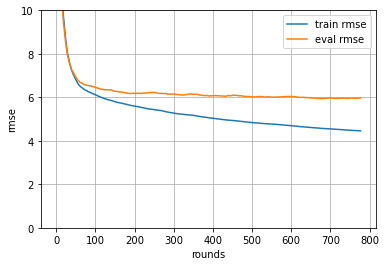

In [42]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [43]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*0.0 + y_lgb_oof_train*1.0

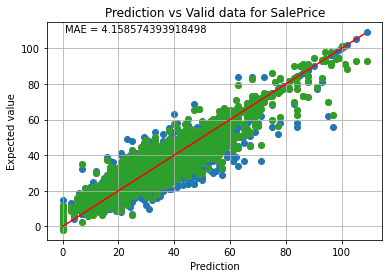

In [44]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_total_pred)
#result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [45]:
# Average of Prediction data (LightGBM)
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [46]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [47]:
submit_sample.head()

,0,1
0,2016-04-01,78.299325
1,2016-04-02,62.715096
2,2016-04-03,64.132339
3,2016-04-04,63.671676
4,2016-04-05,56.554187
